In [29]:
import os
import re
from pathlib import Path
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import skopt
from skopt.plots import plot_convergence

from simulation_utils.calibration import Calibrator, compute_cosine_similarity_pd, _sample_pairs
from simulation_utils.datasets import DataStats, steam_video_game
from simulation_utils.preference import LatentDirichletAllocationCSR, IndianBuffetProcessCSR
from simulation_utils.observation import PopularityObservationCSR, UniformObservationCSR, TruncParetoProfile

# %matplotlib inline

In [2]:
def ibp_unif_pareto(nusers=943, alpha=825.104806974929, c=0.8769365301765374, sigma=0,
                   m=20.00000045, obs_alpha=0.510528, upper=737,
                   fname='ibp_unif.pkl', savetofile=True, cap=True):
    pref = IndianBuffetProcessCSR(nusers, alpha, c, sigma).generate()
    trunc_pareto = TruncParetoProfile(m, obs_alpha, upper, cap)
    obs = UniformObservationCSR(trunc_pareto).sample(pref)
    coo = obs.tocoo(copy=False)
    df = pd.DataFrame({'user': coo.row, 'item': coo.col, 'rating': coo.data})
    if savetofile:
        with open(f'data/simulated/{fname}', 'wb') as f:
            pickle.dump(df, f)
    return df

In [3]:
def ibp_pop_pareto(nusers=943, alpha=825.104806974929, c=0.8769365301765374, sigma=0,
                   m=20.00000045, obs_alpha=0.510528, upper=737,
                   fname='ibp_pop.pkl', savetofile=True, cap=True):
#     pref = generate_ibp_df(943, 1009.2, 10, 0)
    pref = IndianBuffetProcessCSR(nusers, alpha, c, sigma).generate()
    trunc_pareto = TruncParetoProfile(m, obs_alpha, upper, cap)
    obs = PopularityObservationCSR(trunc_pareto).sample(pref)
    coo = obs.tocoo(copy=False)
    df = pd.DataFrame({'user': coo.row, 'item': coo.col, 'rating': coo.data})
    if savetofile:
        with open(f'data/simulated/{fname}', 'wb') as f:
            pickle.dump(df, f)
    return df

In [4]:
def lda_pop_pareto(nusers=943, nitems=1682, k=10, lam=434.8731099953002, a=20.0, b=1.01, 
                   m=20.00000045, alpha=0.510528, upper=737,
                   fname='lda_pop.pkl', savetofile=True, cap=True):
#     pref = generate_ibp_df(943, 1009.2, 10, 0)
    pref = LatentDirichletAllocationCSR(nusers, nitems, k, lam, a, b).generate()
    trunc_pareto = TruncParetoProfile(m, alpha, upper, cap)
    obs = PopularityObservationCSR(trunc_pareto).sample(pref)
    coo = obs.tocoo(copy=False)
    df = pd.DataFrame({'user': coo.row, 'item': coo.col, 'rating': coo.data})
    if savetofile:
        with open(f'data/simulated/{fname}', 'wb') as f:
            pickle.dump(df, f)
    return df

In [5]:
def lda_unif_pareto(nusers=943, nitems=1682, k=10, lam=434.8731099953002, a=20.0, b=1.01, 
                    m=20.00000045, alpha=0.510528, upper=737,
                    fname='lda_unif.pkl', savetofile=True, cap=True):
#     pref = generate_ibp_df(943, 1009.2, 10, 0)
    pref = LatentDirichletAllocationCSR(nusers, nitems, k, lam, a, b).generate()
    trunc_pareto = TruncParetoProfile(m, alpha, upper, cap)
    obs = UniformObservationCSR(trunc_pareto).sample(pref)
    coo = obs.tocoo(copy=False)
    df = pd.DataFrame({'user': coo.row, 'item': coo.col, 'rating': coo.data})
    if savetofile:
        with open(f'data/simulated/{fname}', 'wb') as f:
            pickle.dump(df, f)
    return df

In [6]:
def compute_density(data):
    nusers = len(data['user'].unique())
    nitems = len(data['item'].unique())
    npairs = len(data)
    density = npairs / nitems / nusers
    return nusers, nitems, npairs, density

In [7]:
def compute_data_stats(data):
    pairs = data.loc[:, ['user', 'item']]
    user_activity = pairs.groupby('user', as_index=False).count().rename(columns={'item': 'count'})
    item_popularity = pairs.groupby('item', as_index=False).count().rename(columns={'user': 'count'})
    return user_activity, item_popularity

In [8]:
def summarize_dataset(name, data_func, *args, **kwargs):
    if isinstance(data_func, pd.DataFrame):
        dataset = data_func
    else:
        dataset = data_func(*args, **kwargs)
    colname = dataset.columns
    if not {'user', 'item'}.issubset(colname):
        dataset.rename(columns={colname[0]: 'user',
                                colname[1]: 'item'},
                       inplace=True)
    dataset = dataset[['user', 'item']]
    data_meta = compute_density(dataset)
    data_meta_stats = tuple([name, *data_meta])
    
    user_activity, item_popularity = compute_data_stats(dataset)
    user_activity['dataset'] = name
#     user_activity.drop('user', axis=1, inplace=True)
    item_popularity['dataset'] = name
#     item_popularity.drop('item', axis=1, inplace=True)
    item_popularity['rank'] = item_popularity['count'].rank(method='min', ascending=False)

    user_activity_stats = user_activity['count'].rename(name).describe()
    item_popularity_stats = item_popularity['count'].rename(name).describe()
    return data_meta_stats, user_activity_stats, item_popularity_stats, user_activity, item_popularity

In [9]:
def make_grids(figsize=(14, 6), ngrids_left=3, ngrids_right=1):
    fig = plt.figure(figsize=figsize)
    gs_left = GridSpec(ngrids_left, 1)
    gs_left.update(left=0.05, right=0.48, wspace=0.05, hspace=0.05)
    for i in range(ngrids_left):
        ax = plt.subplot(gs_left[i, 0])
    for ax in fig.axes[:-1]:
        ax.spines['bottom'].set_visible(False)
        ax.tick_params(labelbottom=False, bottom=False)
    for ax in fig.axes[1:]:
        ax.spines['top'].set_visible(False)

    gs_right = GridSpec(ngrids_right, 1)
    gs_right.update(left=0.55, right=0.98, wspace=0.05, hspace=0.05)
    for i in range(ngrids_right):
        ax = plt.subplot(gs_right[i, 0])
    for ax in fig.axes[ngrids_left:-1]:
        ax.spines['bottom'].set_visible(False)
        ax.tick_params(labelbottom=False, bottom=False)
    for ax in fig.axes[ngrids_left+1:]:
        ax.spines['top'].set_visible(False)
    return fig, fig.axes

In [10]:
def make_nested_grids(figsize=(14, 20), ylim_left=(None, None, None, None)):
    fig = plt.figure(figsize=figsize)
    gs_outer = GridSpec(4, 2, figure=fig, wspace=0.3, hspace=0.4)
    for i in range(8):
        if i % 2 == 0:
            ylim = ylim_left[i // 2]
            ngrids = len(ylim) if ylim else 1
            gs_inner = gs_outer[i].subgridspec(ngrids, 1)
            for j in range(ngrids):
                ax = fig.add_subplot(gs_inner[j, :])
                if j < ngrids - 1:
                    ax.spines['bottom'].set_visible(False)
                    ax.tick_params(labelbottom=False, bottom=False)
                if j > 0:
                    ax.spines['top'].set_visible(False)
        else:
            gs_inner = gs_outer[i].subgridspec(1, 1)
            ax = fig.add_subplot(gs_inner[0, :])
    return fig

In [11]:
def plot_stats(base, simulated, base_arg=(), args=(), ylim_left=None, ylim_left2=None, ylim_left4=None, mrated=1):
    """
    Args:
        base (`tuple` of str, function): name and data function
        simulated (`tuple` of `str`, `function`): name and simulated data function
        base_arg: position args for data function
        args: position args for simulated data function
    """
    ml_name, data_func, lda_name, simulated_lda_func = *base, *simulated
    data = data_func(*base_arg)
    data['rating'] = 1
    if callable(simulated_lda_func):
        simulated_lda = simulated_lda_func(*args)
    else:
        simulated_lda = simulated_lda_func
    simulated_lda['rating'] = 1
    ml_meta, ml_uastats, ml_ipstats, ml_ua, ml_ip = summarize_dataset(ml_name, data)
    lda_meta, lda_uastats, lda_ipstats, lda_ua, lda_ip = summarize_dataset(lda_name, simulated_lda)
    # show data stats
    df = pd.DataFrame.from_records([ml_meta, lda_meta],
                                   columns=['dataset', 'nusers', 'nitems', 'npairs', 'density'])
    print('dataset stats')
    print(df)
    df = pd.concat([ml_ipstats, lda_ipstats], axis=1)
    print('item popularity stats')
    print(df)
    df = pd.concat([ml_uastats, lda_uastats], axis=1)
    print('user profile stats')
    print(df)
    # minimum n ratings
    ml_upairs = ml_ua[ml_ua['count'] >= mrated]['user'].values
    ml_ipairs = ml_ip[ml_ip['count'] >= mrated]['item'].values
    lda_upairs = lda_ua[lda_ua['count'] >= mrated]['user'].values
    lda_ipairs = lda_ip[lda_ip['count'] >= mrated]['item'].values
    data_ucosine = data[data['user'].isin(ml_upairs)]
    data_icosine = data[data['item'].isin(ml_ipairs)]
    simulated_lda_ucosine = simulated_lda[simulated_lda['user'].isin(lda_upairs)]
    simulated_lda_icosine = simulated_lda[simulated_lda['item'].isin(lda_ipairs)]

    ml_dcorr = compute_cosine_similarity_pd(data_icosine, _sample_pairs, 'item', 'user')
    lda_dcorr = compute_cosine_similarity_pd(simulated_lda_icosine, _sample_pairs, 'item', 'user')
    data2plot = pd.concat([pd.DataFrame({'dataset': ml_name, 'corr': ml_dcorr}),
                           pd.DataFrame({'dataset': lda_name, 'corr': lda_dcorr})],
                          ignore_index=True)
    hue_order = [ml_name, lda_name]
    colors = dict(zip(hue_order, ['#1f77b4', '#ff7f0e']))
    grid_id = 0
    with sns.plotting_context('talk', 1):
        fig = make_nested_grids(ylim_left=(ylim_left, ylim_left2, None, ylim_left4))
        # plot distributions
        axes = fig.axes[grid_id:grid_id + len(ylim_left)] if ylim_left else fig.axes[grid_id:grid_id + 1]
        for i, ax in enumerate(axes):
            for key, group in data2plot.groupby('dataset'):
                sns.distplot(group['corr'], ax=ax, label=key, color=colors[key], axlabel=False)
                if ylim_left is not None:
                    ax.set_ylim(*ylim_left[i])
            grid_id += 1
#         fig.text(0.07, 0.82, 'Density', ha='center', va='center', rotation='vertical')
        nsubgrids = len(axes)
        axes[nsubgrids // 2].set_ylabel('Density')
        if (nsubgrids % 2) == 0:
            axes[nsubgrids // 2].yaxis.set_label_coords(-0.15, 1)
        else:
            axes[nsubgrids // 2].yaxis.set_label_coords(-0.15, 0.5)
        axes[-1].set_xlabel('I-I Sim')
        axes[0].legend()
        ax = sns.boxplot(x='dataset', y='corr', hue='dataset', hue_order=hue_order, data=data2plot, ax=fig.axes[grid_id], dodge=False)
        ax.legend(loc='upper right')
        ax.set_ylabel('I-I Sim')
        ax.set_xlabel('')
#         fig.suptitle('item item similarity')
        grid_id += 1

        # second plot
        ml_dcorr = compute_cosine_similarity_pd(data_ucosine, _sample_pairs)
        lda_dcorr = compute_cosine_similarity_pd(simulated_lda_ucosine, _sample_pairs)
        data2plot = pd.concat([pd.DataFrame({'dataset': ml_name, 'corr': ml_dcorr}),
                               pd.DataFrame({'dataset': lda_name, 'corr': lda_dcorr})],
                              ignore_index=True)
        axes = fig.axes[grid_id:grid_id + len(ylim_left2)] if ylim_left2 else fig.axes[grid_id:grid_id + 1]
        for i, ax in enumerate(axes):
            grid_id += 1
            for key, group in data2plot.groupby('dataset'):
                sns.distplot(group['corr'], ax=ax, label=key, color=colors[key], axlabel=False)
                if ylim_left2 is not None:
                    ax.set_ylim(*ylim_left2[i])
        nsubgrids = len(axes)
        if (nsubgrids % 2) == 0:
            axes[nsubgrids // 2].yaxis.set_label_coords(-0.15, 1)
        else:
            axes[nsubgrids // 2].yaxis.set_label_coords(-0.15, 0.5)
        axes[nsubgrids // 2].set_ylabel('Density')
        axes[-1].set_xlabel('U-U Sim')
        axes[0].legend()
        ax = sns.boxplot(x='dataset', y='corr', hue='dataset', hue_order=hue_order, data=data2plot, ax=fig.axes[grid_id], dodge=False)
        ax.legend(loc='upper right')
        ax.set_ylabel('U-U Sim')
        ax.set_xlabel('')
#         fig.suptitle('user user similarity')
        grid_id += 1
    
        # third plot
        ax1, ax2 = fig.axes[grid_id:grid_id + 2]
        data2plot = pd.concat([ml_ip, lda_ip], ignore_index=True)
        data2plot = data2plot.rename(columns={'dataset': 'Data'})
        sns.scatterplot('rank', 'count', hue='Data', hue_order=hue_order, ax=ax1, data=data2plot)
        ax1.set(xscale="log", yscale="log")
        ax1.set_xlabel('Popularity Rank')
        ax1.set_ylabel('Number of Items')
#         ax1.set_title('item popularity curve')
        grid_id += 1
        data2plot = data2plot.groupby(['Data', 'count']).size().reset_index().rename(columns={'count': 'popularity', 0: 'count'})
        sns.scatterplot('popularity', 'count', hue='Data', hue_order=hue_order, ax=ax2, data=data2plot)
        ax2.set(xscale="log", yscale="log")
        ax2.set_xlabel('Item Popularity')
        ax2.set_ylabel('Number of Items')
#         ax2.set_title('popularity distribution')
        grid_id += 1

        # fourth plot
        data2plot = pd.concat([ml_ua, lda_ua], ignore_index=True)
        data2plot = data2plot.rename(columns={'dataset': 'Data'})
        axes = fig.axes[grid_id:grid_id + len(ylim_left4)] if ylim_left4 else fig.axes[grid_id:grid_id + 1]
        for i, ax in enumerate(axes):
            grid_id += 1
            for key, group in data2plot.groupby('Data'):
                sns.distplot(group['count'], ax=ax, label=key, color=colors[key], axlabel=False, hist_kws={'alpha':0.5}, kde=False)
                if ylim_left4 is not None:
                    ax.set_ylim(*ylim_left4[i])
        axes[0].legend()
        axes[0].set_title('Histogram')
        axes[-1].set_xlabel('User Activity')
        nsubgrids = len(axes)
        axes[nsubgrids // 2].set_ylabel('Number of Users')
        if (nsubgrids % 2) == 0:
            axes[nsubgrids // 2].yaxis.set_label_coords(-0.2, 1)
        else:
            axes[nsubgrids // 2].yaxis.set_label_coords(-0.2, 0.5)
#         axes[-1].set_ylabel('Number of Users')
        data2plot = data2plot.groupby(['Data', 'count']).size().reset_index().rename(columns={'count': 'User Activity', 0: 'Number of Users'})
        ax = sns.scatterplot('User Activity', 'Number of Users', hue='Data', hue_order=hue_order, ax=fig.axes[grid_id], data=data2plot)
        ax.set_title('Scatter Plot')
        plt.show()

In [12]:
data = ['steam_video_game']
models = ['lda_unif', 'lda_pop', 'ibp_unif', 'ibp_pop', 'unif_unif', 'unif_pop']
metrics = ['ucorr', 'icorr', 'item-pop', 'user-act']
for d in data:
    for m in models:
        for metric in metrics:
            res_gp = skopt.load(f'build/gp_minimize_{m}_csr-{d}-{metric}.pkl')
            print(d, m, metric, res_gp.fun)
            try:
                with open(f'build/params_{m}_csr-{d}-{metric}.pkl', 'rb') as f:
                    params = pickle.load(f)
                if 'lda' in m or 'unif_unif' in m or 'unif_pop' in m:
                    assert params == [70912, 10978, *res_gp.x] 
                elif 'ibp' in m:
                    assert params == [70912, *res_gp.x]
            except:
                if 'lda' in m or 'unif_unif' in m or 'unif_pop' in m:
                    params = [70912, 10978, *res_gp.x]
                elif 'ibp' in m:
                    params = [70912, *res_gp.x]
                print('rewrite params for', d, m, metric, params)
                with open(f'build/params_{m}_csr-{d}-{metric}.pkl', 'wb') as f:
                    pickle.dump(params, f)

steam_video_game lda_unif ucorr 1.1434323122702674
steam_video_game lda_unif icorr 0.1887612563780203
steam_video_game lda_unif item-pop 0.41047559842587034
steam_video_game lda_unif user-act 0.3471992365461162
steam_video_game lda_pop ucorr 0.9718317767225304
steam_video_game lda_pop icorr 0.15231013162766172
steam_video_game lda_pop item-pop 0.37440413391071137
steam_video_game lda_pop user-act 0.35832078159088215
steam_video_game ibp_unif ucorr 0.27372110715476256
steam_video_game ibp_unif icorr 0.13255223501561053
steam_video_game ibp_unif item-pop 0.35120797042494023
steam_video_game ibp_unif user-act 0.35502571225927537
steam_video_game ibp_pop ucorr 0.3393764986119676
steam_video_game ibp_pop icorr 0.21645628445879903
steam_video_game ibp_pop item-pop 0.38245324441123385
steam_video_game ibp_pop user-act 0.44425658970208504
steam_video_game unif_unif ucorr 1.0238397421886989
steam_video_game unif_unif icorr 1.7945127174993871
steam_video_game unif_unif item-pop 3.021304857234076

steam_video_game lda_unif 47.64257076149929


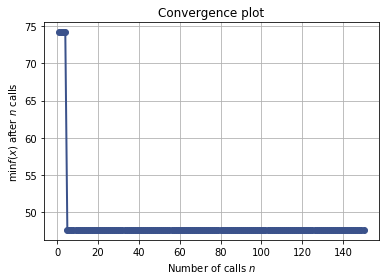

steam_video_game lda_pop 47.194029055479206


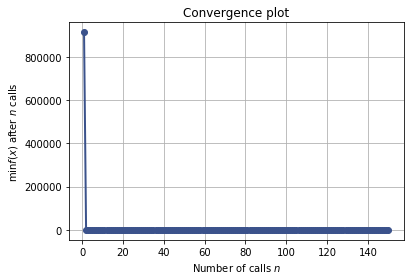

steam_video_game ibp_unif 19.082388540193826


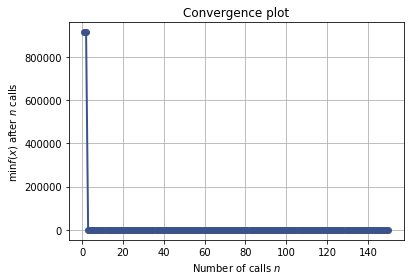

steam_video_game ibp_pop 6.648044304242101


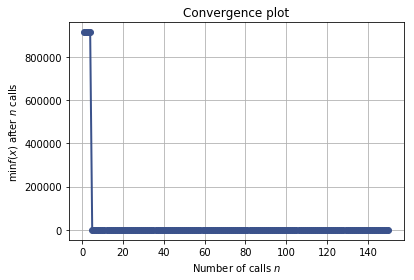

steam_video_game unif_unif 45.213232434905954


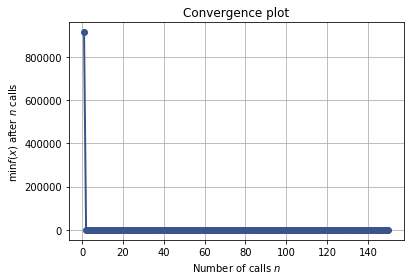

steam_video_game unif_pop 47.43179830296372


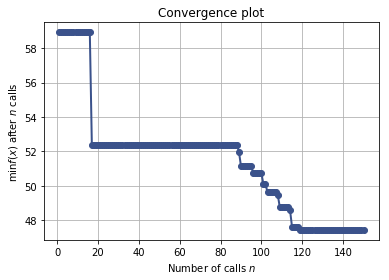

In [13]:
data = ['steam_video_game']
models = ['lda_unif', 'lda_pop', 'ibp_unif', 'ibp_pop', 'unif_unif', 'unif_pop']
for d in data:
    for m in models:   
        res_gp = skopt.load(f'build/skopt_{m}-{d}.pkl')
        print(d, m, res_gp.fun)
        with open(f'build/params_{m}-{d}.pkl', 'rb') as f:
            params = pickle.load(f)
        if 'lda' in m or 'unif_unif' in m or 'unif_pop' in m:
            assert params == [70912, 10978, *res_gp.x] 
        elif 'ibp' in m:
            assert params == [70912, *res_gp.x]
        plot_convergence(res_gp)
        plt.show()

In [14]:
def search_space(file):
    res_gp = skopt.load(file)
    if 'lda' in file:
        labels = ['k', 'lambda', 'a', 'b', 'm', 'alpha', 'upper']
    else:
        labels = ['alpha', 'c', 'sigma', 'm', 'alpha', 'upper']
    print(*zip(labels, zip(np.min(res_gp.x_iters, axis=0), np.max(res_gp.x_iters, axis=0))), res_gp.fun)

In [15]:
search_space('build/gp_minimize_lda_unif_csr-steam_video_game-ucorr-1-2019-04-11-22-02-55.pkl')
search_space('build/gp_minimize_lda_pop_csr-steam_video_game-ucorr-1-2019-04-11-22-11-44.pkl')
search_space('build/gp_minimize_ibp_unif_csr-steam_video_game-ucorr-1-2019-04-11-22-09-12.pkl')
search_space('build/gp_minimize_ibp_pop_csr-steam_video_game-ucorr-1-2019-04-11-22-09-36.pkl')
search_space('build/gp_minimize_lda_unif_csr-steam_video_game-all-1-2019-04-11-22-03-16.pkl')

('k', (15.0, 188.0)) ('lambda', (19.25917272922809, 335.780221319102)) ('a', (0.07024411101590769, 0.8435450685672067)) ('b', (0.01600737044297738, 0.9056191046474779)) ('m', (1.0150059374700697, 1.1750248707938347)) ('alpha', (0.3203547109897399, 19.95618474991416)) ('upper', (6334.952506585138, 8576.878228408354)) 1.9396730097853794
('k', (19.0, 199.0)) ('lambda', (5.544000098076546, 368.19874146470937)) ('a', (0.028738352744700678, 0.9263600224113085)) ('b', (0.04990613098064855, 0.7481401810537979)) ('m', (1.003669131166352, 1.080445181409723)) ('alpha', (1.2305249505167402, 18.234157936403566)) ('upper', (7087.800910801533, 8063.001353557557)) 1.8655445455639372
('alpha', (20.401616408381148, 404.2868884632619)) ('c', (0.048646799784767374, 96.70974767224114)) ('sigma', (0.04705018965148844, 0.8643311935898588)) ('m', (1.0029525681617142, 1.1965857336356076)) ('alpha', (1.8724364049308786, 18.359284952019387)) ('upper', (6318.457635611956, 8935.989337503803)) 3.3536106303668825
('

## Steam Video Game

### lda unif on user user

In [16]:
search_space('build/gp_minimize_lda_unif_csr-steam_video_game-ucorr-1-2019-04-11-22-02-55.pkl')
search_space('build/gp_minimize_lda_unif_csr-steam_video_game-ucorr.pkl')

('k', (15.0, 188.0)) ('lambda', (19.25917272922809, 335.780221319102)) ('a', (0.07024411101590769, 0.8435450685672067)) ('b', (0.01600737044297738, 0.9056191046474779)) ('m', (1.0150059374700697, 1.1750248707938347)) ('alpha', (0.3203547109897399, 19.95618474991416)) ('upper', (6334.952506585138, 8576.878228408354)) 1.9396730097853794
('k', (10.0, 189.0)) ('lambda', (6.317167194021579, 1779.1156626219595)) ('a', (0.07350281880851216, 0.9927138745956225)) ('b', (0.015011575522517778, 0.9745458453951723)) ('m', (1.0019498212798652, 1.1919822717401218)) ('alpha', (0.1, 19.717977458820332)) ('upper', (6250.575771808142, 9081.564453414072)) 1.1434323122702674


In [33]:
res_gp.func_vals

array([1.00000000e+06, 7.69104709e+00, 5.92621069e+00, 1.00000000e+06,
       3.55844556e+00, 1.00000000e+06, 1.00000000e+06, 1.14343231e+00,
       1.00000000e+06, 1.00000000e+06, 1.00000000e+06, 1.00000000e+06,
       1.00000000e+06, 1.00000000e+06, 8.03104565e+00, 1.00000000e+06,
       1.00000000e+06, 1.00000000e+06, 1.00000000e+06, 1.00000000e+06,
       1.00000000e+06, 6.02316232e+00, 1.00000000e+06, 6.29579791e+00,
       1.00000000e+06, 1.00000000e+06, 6.30677658e+00, 6.15541241e+00,
       6.19330635e+00, 6.10896390e+00, 6.19808202e+00, 6.13179839e+00,
       6.08330349e+00, 6.10415999e+00, 6.12198713e+00, 6.11242684e+00,
       6.12157145e+00, 6.07813387e+00, 6.07752769e+00, 6.10116242e+00,
       6.11308952e+00, 6.10226920e+00, 6.00214122e+00, 6.01127820e+00,
       6.18740712e+00, 6.14835319e+00, 6.03669274e+00, 6.14522242e+00,
       5.99918497e+00, 6.15796261e+00, 6.02023867e+00, 6.19151601e+00,
       6.02783619e+00, 6.05442813e+00, 6.13588371e+00, 6.02530050e+00,
      

In [35]:
res_gp = skopt.load('build/gp_minimize_lda_unif_csr-steam_video_game-ucorr.pkl')
for x in zip(res_gp.x_iters, res_gp.func_vals):
    print(x[0], x[1], x[-1])

[102, 113.13673065765143, 0.9443875047371495, 0.14282025199665008, 1.1468266732074017, 15.843122464926829, 8657.791388259328] 1000000.0 1000000.0
[55, 7.529476581193363, 0.49214511447440434, 0.6166658465747582, 1.0123838483573027, 0.9613739606713644, 6569.097608992358] 7.691047086504449 7.691047086504449
[10, 500.2832674316511, 0.14390177524500047, 0.16614906895007245, 1.0487420434323935, 2.6055729315937652, 6746.574010752803] 5.926210689971227 5.926210689971227
[119, 43.127342712607884, 0.4389155560612499, 0.5379633062118255, 1.0542685870521455, 19.445894083725033, 8005.823925727154] 1000000.0 1000000.0
[115, 7.324586631633659, 0.9819015748954727, 0.02881683828679403, 1.0746093912083754, 4.240982553797304, 7907.9024280383965] 3.5584455605295586 3.5584455605295586
[189, 111.6019218382185, 0.38351804348780294, 0.2209326728222659, 1.167543636226065, 6.915298285317031, 6250.575771808142] 1000000.0 1000000.0
[32, 12.969901687778725, 0.5601288114470258, 0.28024454469843846, 1.12548756214736

[79, 375.2325593739978, 0.6188409955776204, 0.5377232387313327, 1.0799458555173131, 5.528815117208289, 6741.969976085181] 1.1434323122702674
simulated data is used
dataset stats
    dataset  nusers  nitems   npairs   density
0     STMV1   70912   10978  5094082  0.006544
1  LDA-Unif   70912   10890    73833  0.000096
item popularity stats
              STMV1      LDA-Unif
count  10978.000000  10890.000000
mean     464.026416      6.779890
std     1793.593696      3.436492
min        1.000000      1.000000
25%        9.000000      4.000000
50%       43.000000      6.000000
75%      220.000000      9.000000
max    49136.000000     24.000000
user profile stats
              STMV1      LDA-Unif
count  70912.000000  70912.000000
mean      71.836671      1.041192
std      132.366763      0.243622
min        1.000000      1.000000
25%       14.000000      1.000000
50%       40.000000      1.000000
75%       87.000000      1.000000
max     7762.000000     11.000000


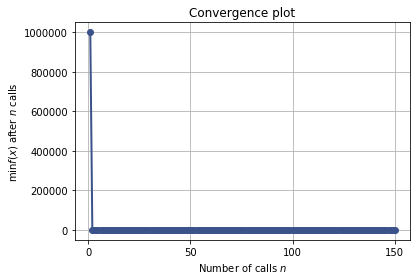

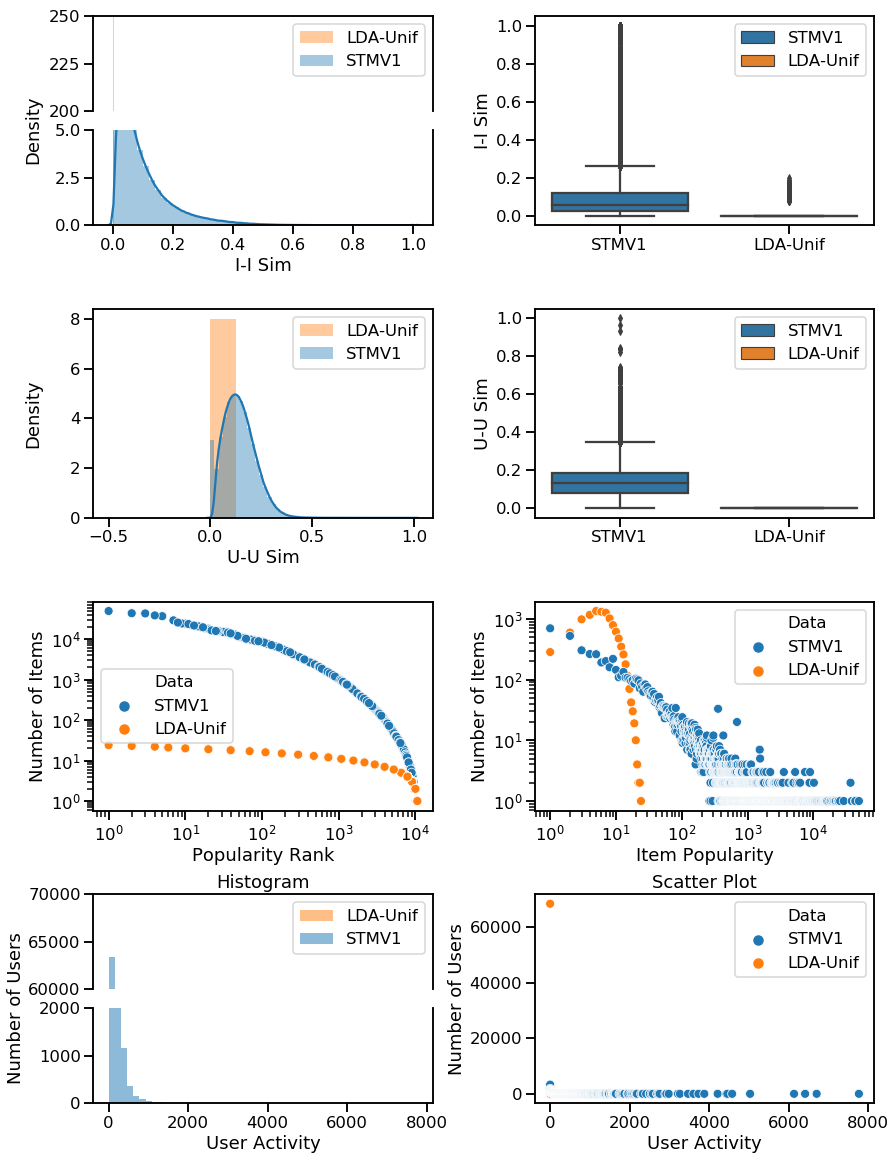

In [20]:
res_gp = skopt.load('build/gp_minimize_lda_unif_csr-steam_video_game-ucorr.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/lda_unif_csr-steam_video_game-ucorr.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('stmvg', steam_video_game), ('lda_unif', lda_unif_pareto), args=[70912, 10978, *res_gp.x, 'lda_unif_csr-steam_video_game-ucorr.pkl'],
               ylim_left=((40, 50), (0, 20)), ylim_left2=((70, 80), (40, 50), (0, 10)),
               ylim_left4=((2000, 5000), (0, 1000)), mrated=5)
else:
    print('simulated data is used')
    plot_stats(('STMV1', steam_video_game), ('LDA-Unif', simulated_data), 
               ylim_left=((200, 250), (0, 10)),
               ylim_left4=((60000, 70000), (0, 2000)), mrated=5)

### lda unif on item item

[5, 2000.0, 1.0, 0.01, 1.0, 0.1, 6209.6] 0.1887612563780203
simulated data is used
dataset stats
    dataset  nusers  nitems   npairs   density
0     STMV1   70912   10978  5094082  0.006544
1  LDA-Unif   70912    3886  2218013  0.008049
item popularity stats
              STMV1     LDA-Unif
count  10978.000000  3886.000000
mean     464.026416   570.770201
std     1793.593696  1051.174676
min        1.000000     1.000000
25%        9.000000     9.000000
50%       43.000000    78.000000
75%      220.000000   572.750000
max    49136.000000  6735.000000
user profile stats
              STMV1      LDA-Unif
count  70912.000000  70912.000000
mean      71.836671     31.278387
std      132.366763     73.643374
min        1.000000      1.000000
25%       14.000000      1.000000
50%       40.000000      3.000000
75%       87.000000     15.000000
max     7762.000000    375.000000


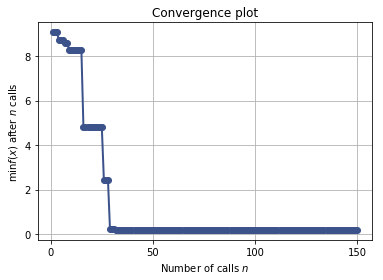

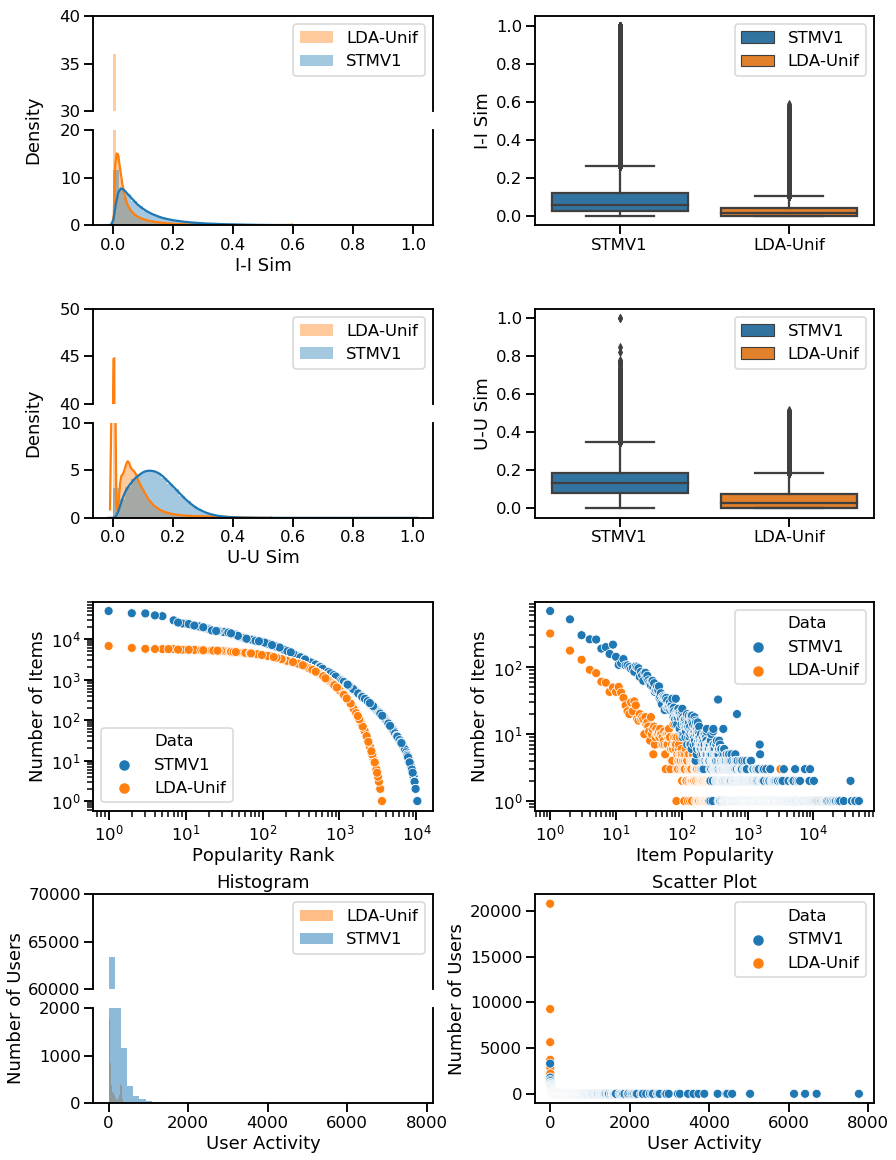

In [20]:
res_gp = skopt.load('build/gp_minimize_lda_unif_csr-steam_video_game-icorr.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/lda_unif_csr-steam_video_game-icorr.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('stmvg', steam_video_game), ('lda_unif', lda_unif_pareto), args=[70912, 10978, *res_gp.x, 'lda_unif_csr-steam_video_game-icorr.pkl'],
               ylim_left=((40, 50), (0, 20)), ylim_left2=((70, 80), (40, 50), (0, 10)),
               ylim_left4=((2000, 5000), (0, 1000)), mrated=5)
else:
    print('simulated data is used')
    plot_stats(('STMV1', steam_video_game), ('LDA-Unif', simulated_data), mrated=5,
               ylim_left=((30, 40), (0, 20)), ylim_left2=((40, 50), (0, 10)),
               ylim_left4=((60000, 70000), (0, 2000)))

### lda unif on item pop

In [16]:
search_space('build/gp_minimize_lda_unif_csr-steam_video_game-item-pop.pkl')

('k', (5.0, 200.0)) ('lambda', (20.000000000000004, 499.99999999999994)) ('a', (0.01, 1.0)) ('b', (0.01, 1.0)) ('m', (1.0, 1.2)) ('alpha', (0.1, 20.0)) ('upper', (2000.0000000000002, 9314.4)) 0.41047559842587034


[47, 20.000000000000004, 1.0, 0.01, 1.1751841266313863, 0.1, 9314.4] 0.41047559842587034
simulated data is used
dataset stats
    dataset  nusers  nitems   npairs   density
0     STMV1   70912   10978  5094082  0.006544
1  LDA-Unif   70912   10088   988536  0.001382
item popularity stats
              STMV1      LDA-Unif
count  10978.000000  10088.000000
mean     464.026416     97.991277
std     1793.593696    134.334917
min        1.000000      1.000000
25%        9.000000     13.000000
50%       43.000000     47.000000
75%      220.000000    129.000000
max    49136.000000   1700.000000
user profile stats
              STMV1      LDA-Unif
count  70912.000000  70912.000000
mean      71.836671     13.940320
std      132.366763      8.380506
min        1.000000      1.000000
25%       14.000000      5.000000
50%       40.000000     16.000000
75%       87.000000     21.000000
max     7762.000000     42.000000


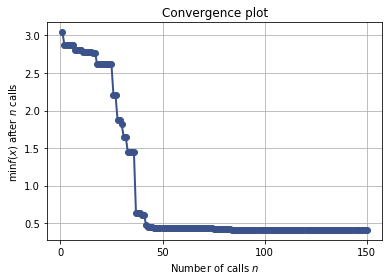

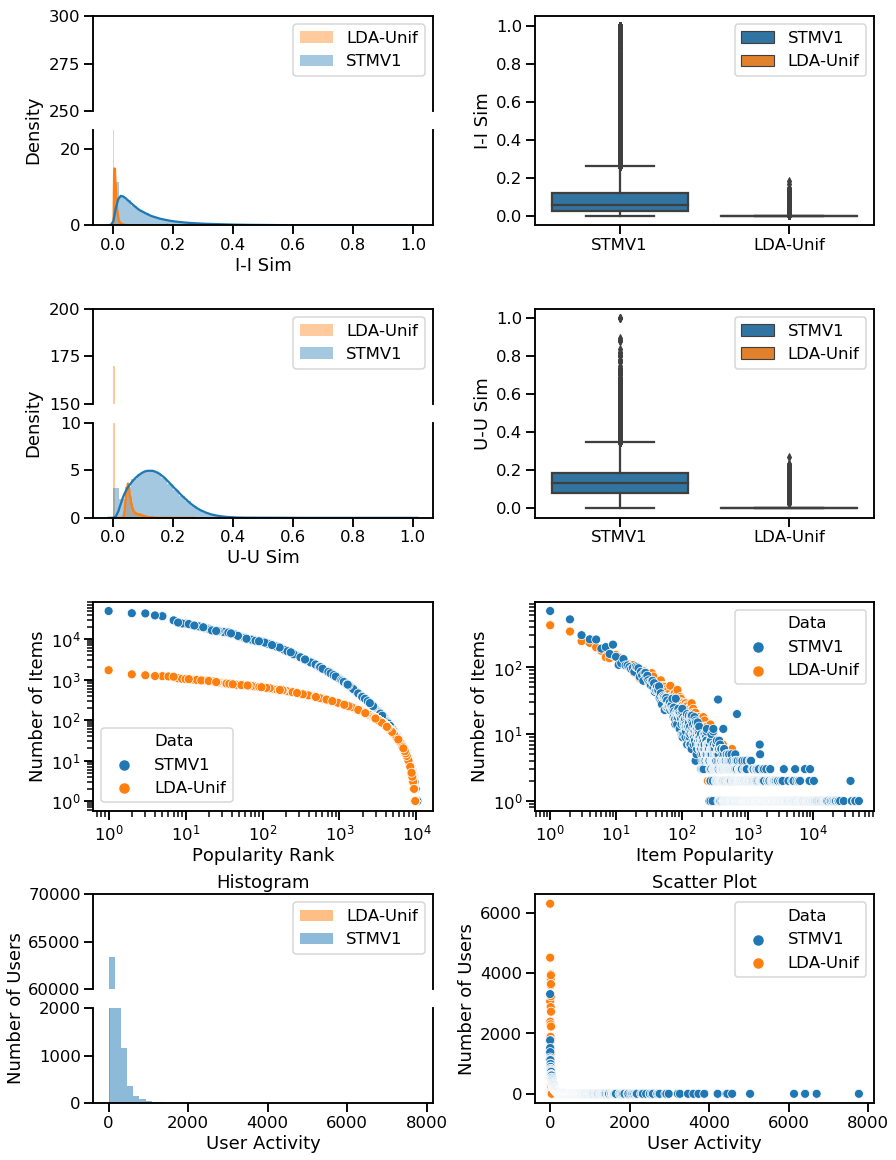

In [19]:
res_gp = skopt.load('build/gp_minimize_lda_unif_csr-steam_video_game-item-pop.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/lda_unif_csr-steam_video_game-item-pop.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('stmvg', steam_video_game), ('lda_unif', lda_unif_pareto), args=[70912, 10978, *res_gp.x, 'lda_unif_csr-steam_video_game-item-pop.pkl'],
               ylim_left=((40, 50), (0, 20)), ylim_left2=((70, 80), (40, 50), (0, 10)),
               ylim_left4=((2000, 5000), (0, 1000)), mrated=1)
else:
    print('simulated data is used')
    plot_stats(('STMV1', steam_video_game), ('LDA-Unif', simulated_data), 
               ylim_left=((250, 300), (0, 25)), ylim_left2=((150, 200), (0, 10)),
               ylim_left4=((60000, 70000), (0, 2000)), mrated=5)

### lda unif on user activity

[86, 499.99999999999994, 0.01, 0.01, 1.2, 0.1, 2000.0000000000002] 0.3471992365461162
simulated data is used
dataset stats
    dataset  nusers  nitems    npairs   density
0     STMV1   70912   10978   5094082  0.006544
1  LDA-Unif   70912   10978  24423756  0.031374
item popularity stats
              STMV1      LDA-Unif
count  10978.000000  10978.000000
mean     464.026416   2224.791037
std     1793.593696    180.182798
min        1.000000   1566.000000
25%        9.000000   2099.000000
50%       43.000000   2222.000000
75%      220.000000   2346.000000
max    49136.000000   2902.000000
user profile stats
              STMV1      LDA-Unif
count  70912.000000  70912.000000
mean      71.836671    344.423454
std      132.366763    589.875400
min        1.000000      1.000000
25%       14.000000      5.000000
50%       40.000000     34.000000
75%       87.000000    341.000000
max     7762.000000   1962.000000


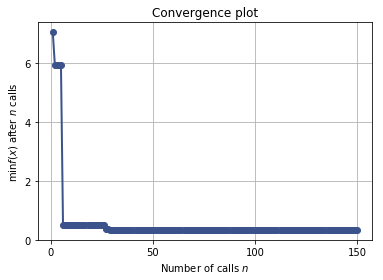

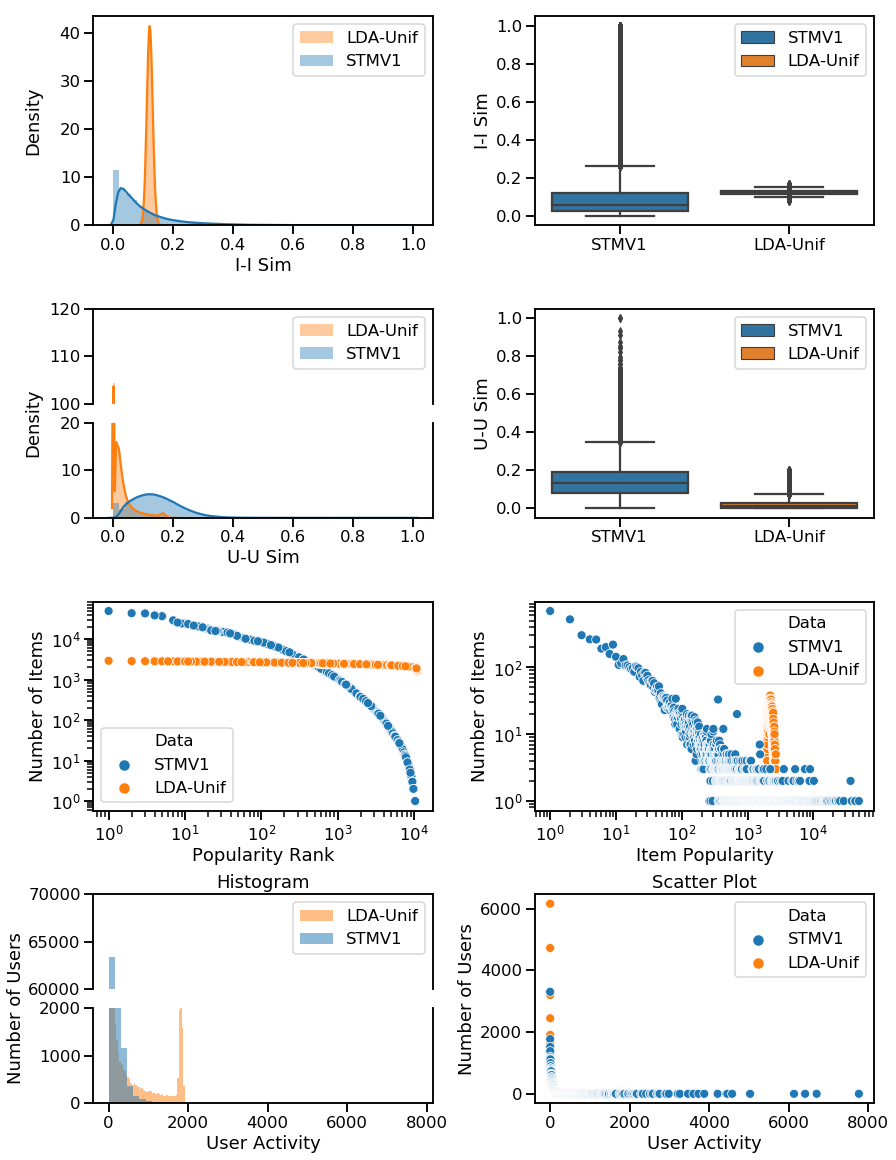

In [21]:
res_gp = skopt.load('build/gp_minimize_lda_unif_csr-steam_video_game-user-act.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/lda_unif_csr-steam_video_game-user-act.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('stmvg', steam_video_game), ('lda_unif', lda_unif_pareto), args=[70912, 10978, *res_gp.x, 'lda_unif_csr-steam_video_game-user-act.pkl'],
               ylim_left=((40, 50), (0, 20)), ylim_left2=((70, 80), (40, 50), (0, 10)),
               ylim_left4=((2000, 5000), (0, 1000)), mrated=5)
else:
    print('simulated data is used')
    plot_stats(('STMV1', steam_video_game), ('LDA-Unif', simulated_data),
               ylim_left=None, ylim_left2=((100, 120), (0, 20)),
               ylim_left4=((60000, 70000), (0, 2000)), mrated=5)

### lda unif on relative loss

[142, 143.66919663182176, 0.4977191427245119, 0.08944143392017219, 1.0365543319126183, 1.4624088658824546, 314.88706601947973] 47.64257076149929
simulated data is used
dataset stats
    dataset  nusers  nitems   npairs   density
0     STMV1   70912   10978  5094082  0.006544
1  LDA-Unif   70912   10977   183979  0.000236
item popularity stats
              STMV1      LDA-Unif
count  10978.000000  10977.000000
mean     464.026416     16.760408
std     1793.593696      6.206877
min        1.000000      1.000000
25%        9.000000     12.000000
50%       43.000000     16.000000
75%      220.000000     21.000000
max    49136.000000     47.000000
user profile stats
              STMV1      LDA-Unif
count  70912.000000  70912.000000
mean      71.836671      2.594469
std      132.366763      6.081775
min        1.000000      1.000000
25%       14.000000      1.000000
50%       40.000000      1.000000
75%       87.000000      2.000000
max     7762.000000    172.000000


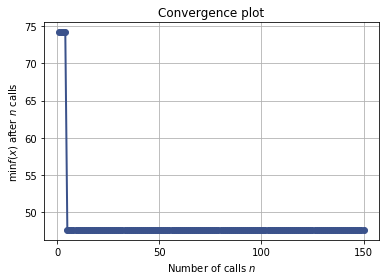

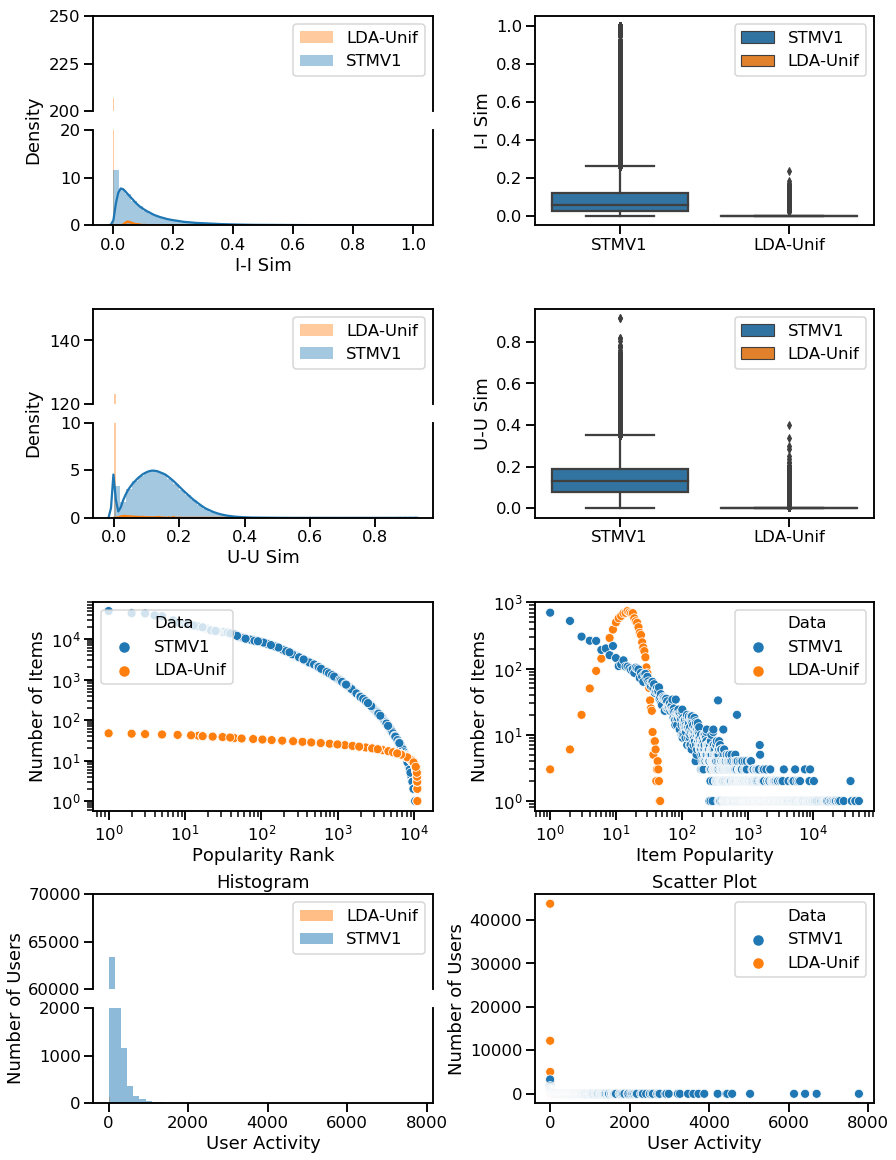

In [43]:
res_gp = skopt.load('build/skopt_lda_unif-steam_video_game.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/lda_unif-steam_video_game.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('STMV1', steam_video_game), ('LDA-Unif', lda_unif_pareto), args=[70912, 10978, *res_gp.x, 'lda_unif-steam_video_game.pkl'])
else:
    print('simulated data is used')
    plot_stats(('STMV1', steam_video_game), ('LDA-Unif', simulated_data), 
               ylim_left=((200, 250), (0, 20)), ylim_left2=((120, 150), (0, 10)),
               ylim_left4=((60000, 70000), (0, 2000)), mrated=5)

### lda pop on item item

[5, 499.99999999999994, 0.9467873150499249, 0.01, 1.031147256312769, 0.5656894063891176, 6941.344549610337] 0.15231013162766172
simulated data is used
dataset stats
   dataset  nusers  nitems   npairs   density
0    STMV1   70912   10978  5094082  0.006544
1  LDA-Pop   70912    3474  1740104  0.007064
item popularity stats
              STMV1      LDA-Pop
count  10978.000000  3474.000000
mean     464.026416   500.893495
std     1793.593696  1078.142688
min        1.000000     1.000000
25%        9.000000     5.000000
50%       43.000000    45.000000
75%      220.000000   379.750000
max    49136.000000  7712.000000
user profile stats
              STMV1       LDA-Pop
count  70912.000000  70912.000000
mean      71.836671     24.538921
std      132.366763     63.391604
min        1.000000      1.000000
25%       14.000000      1.000000
50%       40.000000      3.000000
75%       87.000000     11.000000
max     7762.000000    378.000000


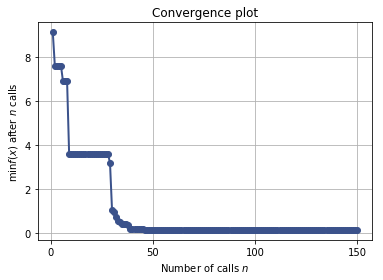

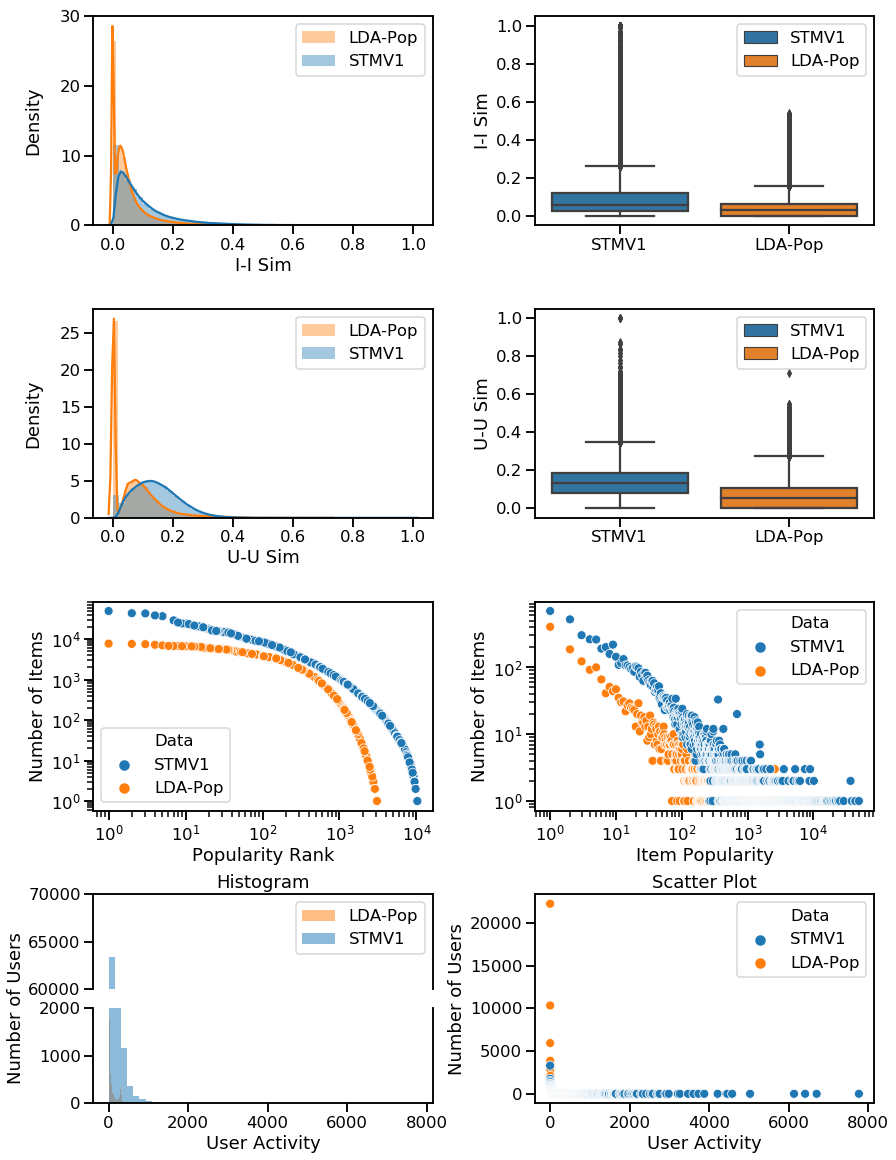

In [44]:
res_gp = skopt.load('build/gp_minimize_lda_pop_csr-steam_video_game-icorr.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/lda_pop_csr-steam_video_game-icorr.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('stmvg', steam_video_game), ('lda_pop', lda_pop_pareto), args=[70912, 10978, *res_gp.x, 'lda_pop_csr-steam_video_game-icorr.pkl'],
               ylim_left=((40, 50), (0, 20)), ylim_left2=((70, 80), (40, 50), (0, 10)),
               ylim_left4=((2000, 5000), (0, 1000)), mrated=5)
else:
    print('simulated data is used')
    plot_stats(('STMV1', steam_video_game), ('LDA-Pop', simulated_data), 
               ylim_left=None, ylim_left2=None,
               ylim_left4=((60000, 70000), (0, 2000)), mrated=5)

### lda pop on user user

[42, 994.4894663348573, 0.3731428798297288, 0.22790308175669557, 1.1313971536688645, 5.733397674276846, 8056.222417106842] 0.9718317767225304
simulated data is used
dataset stats
   dataset  nusers  nitems   npairs   density
0    STMV1   70912   10978  5094082  0.006544
1  LDA-Pop   70912   10656    73904  0.000098
item popularity stats
              STMV1       LDA-Pop
count  10978.000000  10656.000000
mean     464.026416      6.935435
std     1793.593696      4.803932
min        1.000000      1.000000
25%        9.000000      3.000000
50%       43.000000      6.000000
75%      220.000000      9.000000
max    49136.000000     38.000000
user profile stats
              STMV1       LDA-Pop
count  70912.000000  70912.000000
mean      71.836671      1.042193
std      132.366763      0.227180
min        1.000000      1.000000
25%       14.000000      1.000000
50%       40.000000      1.000000
75%       87.000000      1.000000
max     7762.000000      7.000000


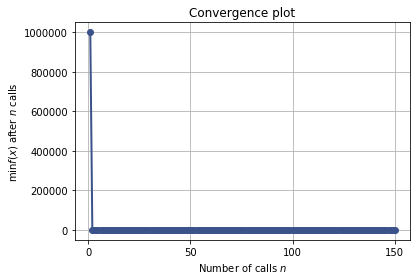

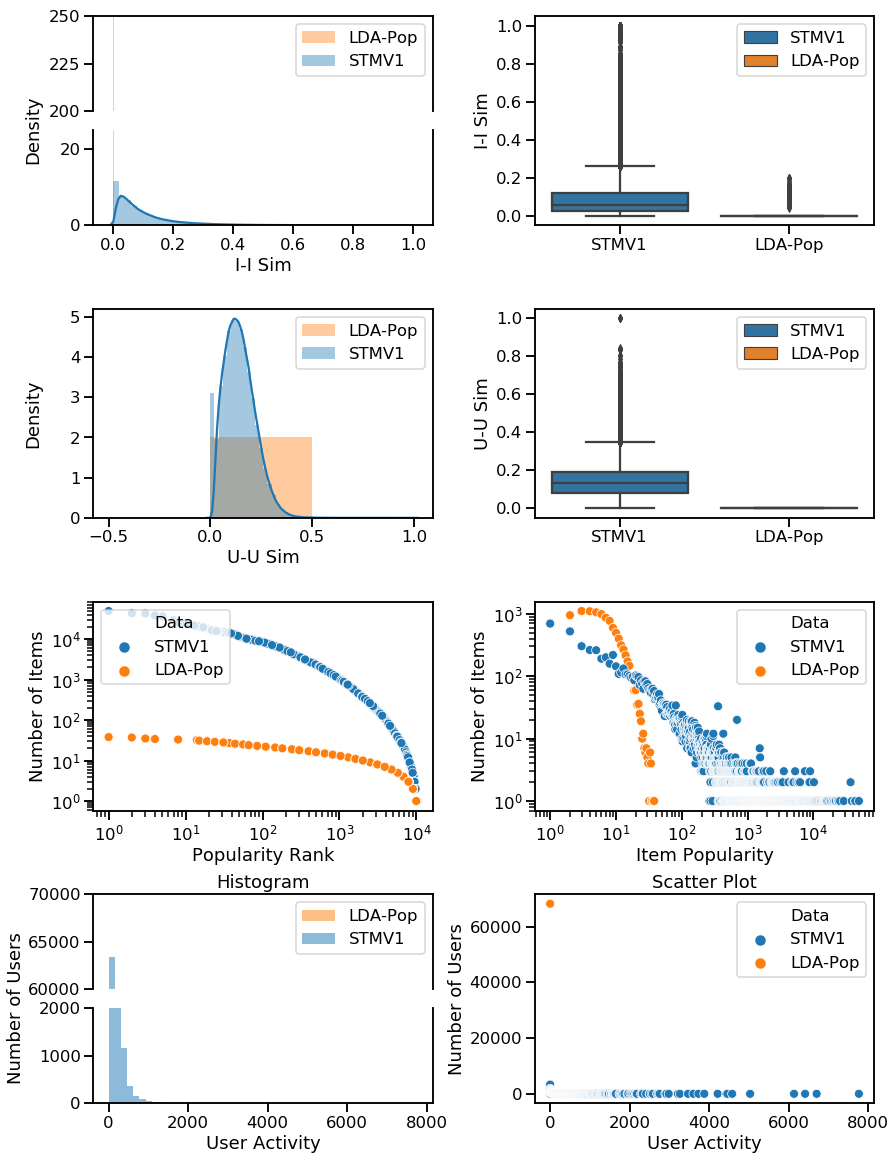

In [22]:
res_gp = skopt.load('build/gp_minimize_lda_pop_csr-steam_video_game-ucorr.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/lda_pop_csr-steam_video_game-ucorr.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('STMV1', steam_video_game), ('LDA-Pop', lda_pop_pareto), args=[70912, 10978, *res_gp.x, 'lda_pop_csr-steam_video_game-ucorr.pkl'],
               ylim_left=((40, 50), (0, 20)), ylim_left2=((70, 80), (40, 50), (0, 10)),
               ylim_left4=((2000, 5000), (0, 1000)), mrated=5)
else:
    print('simulated data is used')
    plot_stats(('STMV1', steam_video_game), ('LDA-Pop', simulated_data), 
               ylim_left=((200, 250), (0, 25)), ylim_left2=None,
               ylim_left4=((60000, 70000), (0, 2000)), mrated=5)

### lda pop on item pop

[33, 58.41935508196702, 0.8912531983755388, 0.014326838726124055, 1.052540639865315, 0.21469157693759167, 2000.0000000000002] 0.37440413391071137
simulated data is used
dataset stats
   dataset  nusers  nitems   npairs   density
0    STMV1   70912   10978  5094082  0.006544
1  LDA-Pop   70912   10166  1478033  0.002050
item popularity stats
              STMV1       LDA-Pop
count  10978.000000  10166.000000
mean     464.026416    145.389829
std     1793.593696    215.479540
min        1.000000      1.000000
25%        9.000000     13.000000
50%       43.000000     55.000000
75%      220.000000    187.750000
max    49136.000000   1955.000000
user profile stats
              STMV1       LDA-Pop
count  70912.000000  70912.000000
mean      71.836671     20.843200
std      132.366763     97.342353
min        1.000000      1.000000
25%       14.000000      1.000000
50%       40.000000      3.000000
75%       87.000000      7.000000
max     7762.000000   1194.000000


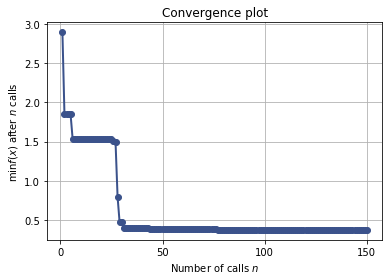

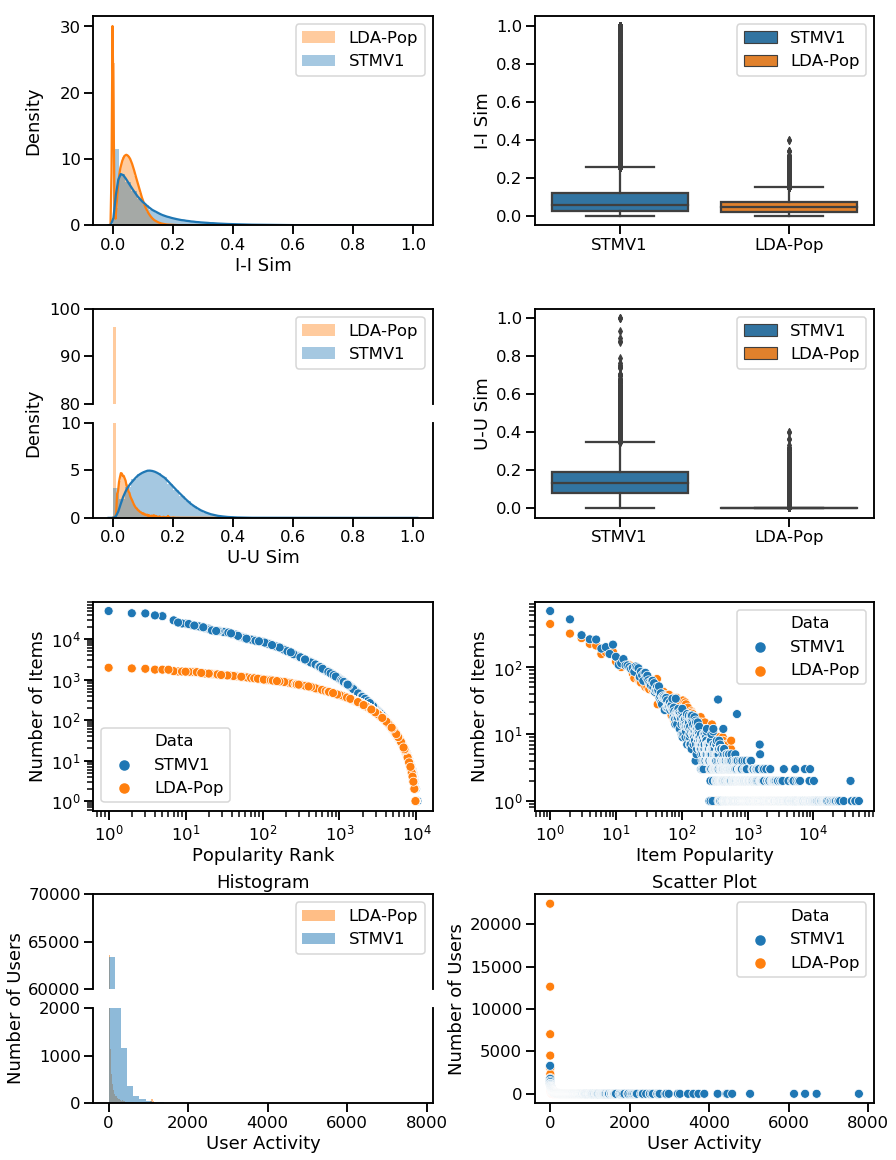

In [23]:
res_gp = skopt.load('build/gp_minimize_lda_pop_csr-steam_video_game-item-pop.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/lda_pop_csr-steam_video_game-item-pop.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('stmvg', steam_video_game), ('lda_pop', lda_pop_pareto), args=[70912, 10978, *res_gp.x, 'lda_pop_csr-steam_video_game-item-pop.pkl'],
               ylim_left=((40, 50), (0, 20)), ylim_left2=((70, 80), (40, 50), (0, 10)),
               ylim_left4=((2000, 5000), (0, 1000)), mrated=1)
else:
    print('simulated data is used')
    plot_stats(('STMV1', steam_video_game), ('LDA-Pop', simulated_data), 
               ylim_left=None, ylim_left2=((80, 100), (0, 10)),
               ylim_left4=((60000, 70000), (0, 2000)), mrated=5)

### lda pop on user activity

[5, 499.99999999999994, 1.0, 1.0, 1.2, 0.1, 2000.0000000000002] 0.35832078159088215
simulated data is used
dataset stats
   dataset  nusers  nitems   npairs   density
0    STMV1   70912   10978  5094082  0.006544
1  LDA-Pop   70912   10978  8702457  0.011179
item popularity stats
              STMV1      LDA-Pop
count  10978.000000  10978.00000
mean     464.026416    792.71789
std     1793.593696    449.98027
min        1.000000     41.00000
25%        9.000000    467.00000
50%       43.000000    708.00000
75%      220.000000   1018.75000
max    49136.000000   4114.00000
user profile stats
              STMV1       LDA-Pop
count  70912.000000  70912.000000
mean      71.836671    122.721923
std      132.366763    174.067566
min        1.000000      1.000000
25%       14.000000      4.000000
50%       40.000000     25.000000
75%       87.000000    175.000000
max     7762.000000    564.000000


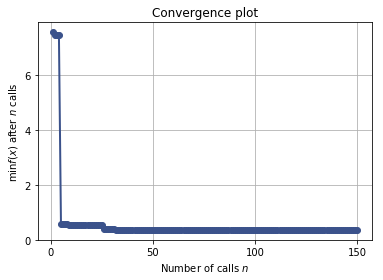

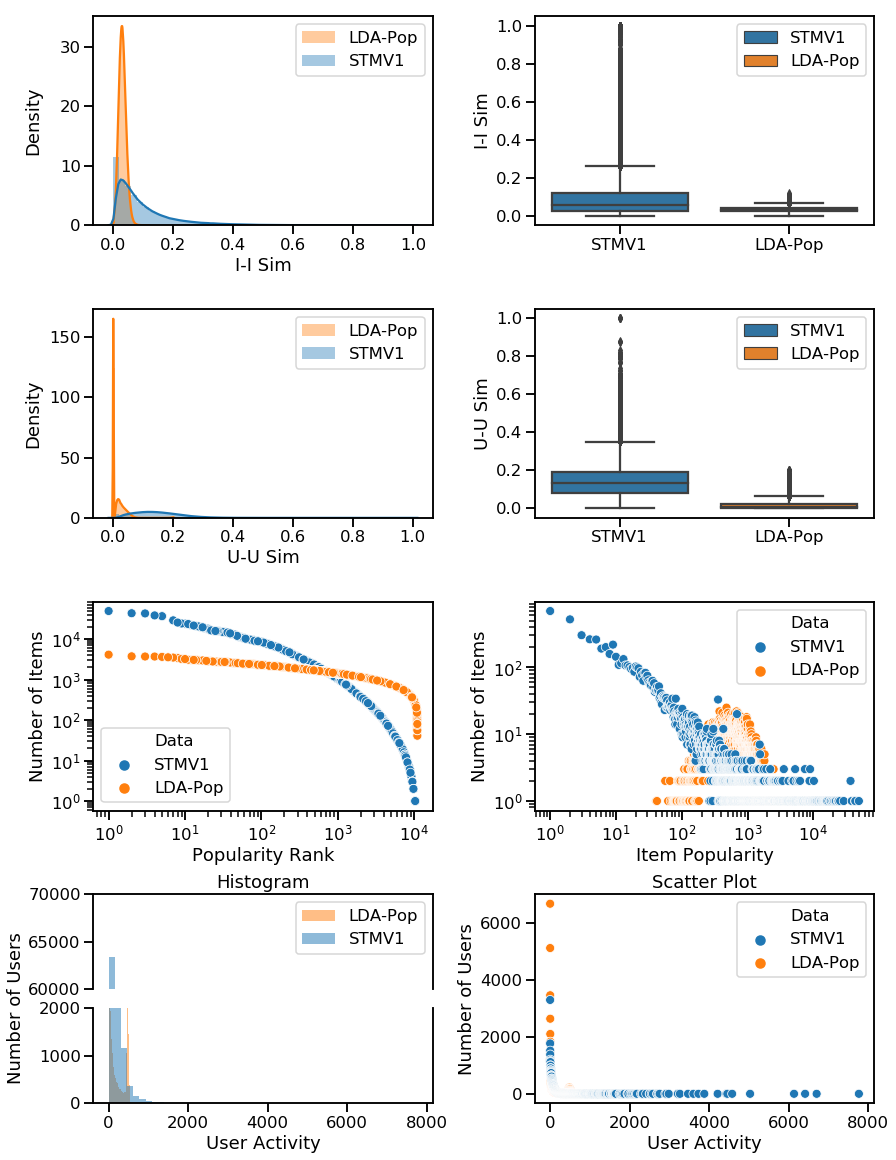

In [24]:
res_gp = skopt.load('build/gp_minimize_lda_pop_csr-steam_video_game-user-act.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/lda_pop_csr-steam_video_game-user-act.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('stmvg', steam_video_game), ('lda_pop', lda_pop_pareto), args=[70912, 10978, *res_gp.x, 'lda_pop_csr-steam_video_game-user-act.pkl'],
               ylim_left=((40, 50), (0, 20)), ylim_left2=((70, 80), (40, 50), (0, 10)),
               ylim_left4=((2000, 5000), (0, 1000)), mrated=1)
else:
    print('simulated data is used')
    plot_stats(('STMV1', steam_video_game), ('LDA-Pop', simulated_data), 
               ylim_left=None, ylim_left2=None,
               ylim_left4=((60000, 70000), (0, 2000)), mrated=5)

### lda pop on relative loss

[84, 63.027199375841874, 0.5855227496363469, 0.38768936242634194, 1.1901907134264693, 1.4653941584549544, 364.61650642391845] 47.194029055479206
simulated data is used
dataset stats
   dataset  nusers  nitems   npairs   density
0    STMV1   70912   10978  5094082  0.006544
1  LDA-Pop   70912   10976   201606  0.000259
item popularity stats
              STMV1       LDA-Pop
count  10978.000000  10976.000000
mean     464.026416     18.367894
std     1793.593696      7.457350
min        1.000000      1.000000
25%        9.000000     13.000000
50%       43.000000     17.000000
75%      220.000000     23.000000
max    49136.000000     67.000000
user profile stats
              STMV1       LDA-Pop
count  70912.000000  70912.000000
mean      71.836671      2.843045
std      132.366763      5.291451
min        1.000000      1.000000
25%       14.000000      1.000000
50%       40.000000      1.000000
75%       87.000000      3.000000
max     7762.000000     84.000000


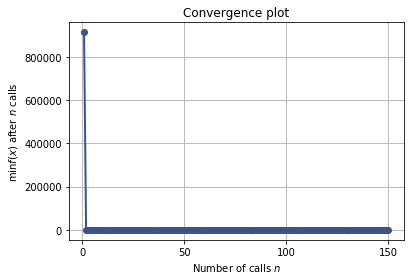

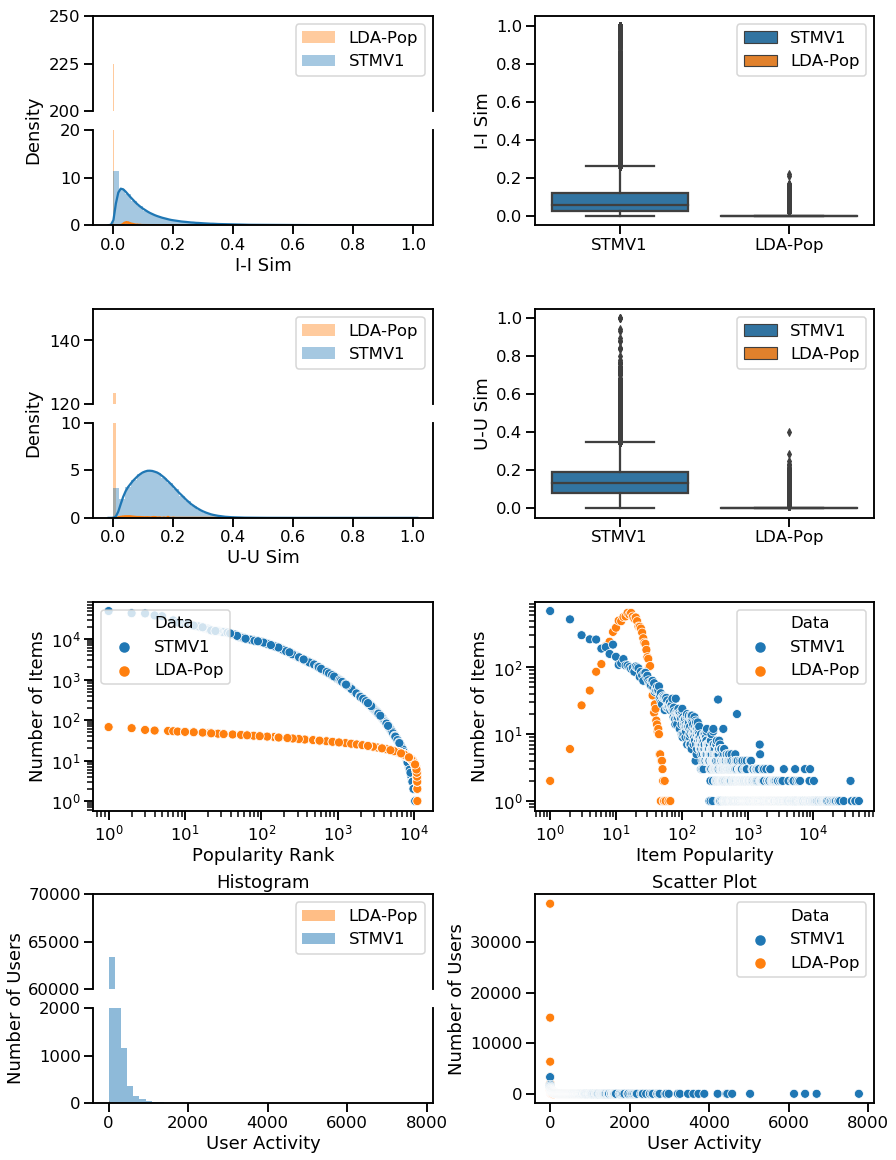

In [42]:
res_gp = skopt.load('build/skopt_lda_pop-steam_video_game.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/lda_pop-steam_video_game.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('STMV1', steam_video_game), ('LDA-Pop', lda_pop_pareto), args=[70912, 10978, *res_gp.x, 'lda_pop-steam_video_game.pkl'])
else:
    print('simulated data is used')
    plot_stats(('STMV1', steam_video_game), ('LDA-Pop', simulated_data),
               ylim_left=((200, 250), (0, 20)), ylim_left2=((120, 150), (0, 10)),
               ylim_left4=((60000, 70000), (0, 2000)), mrated=5)

### ibp unif on item item

[499.99999999999994, 0.15061962628758674, 0.10210945599141287, 1.0, 0.6616296003214578, 9099.515218151526] 0.13255223501561053
simulated data is used
dataset stats
    dataset  nusers  nitems   npairs   density
0     STMV1   70912   10978  5094082  0.006544
1  IBP-Unif   70912    1521  7566767  0.070155
item popularity stats
              STMV1      IBP-Unif
count  10978.000000   1521.000000
mean     464.026416   4974.863248
std     1793.593696   8173.166628
min        1.000000      1.000000
25%        9.000000     12.000000
50%       43.000000    247.000000
75%      220.000000   6205.000000
max    49136.000000  25822.000000
user profile stats
              STMV1      IBP-Unif
count  70912.000000  70912.000000
mean      71.836671    106.706439
std      132.366763    123.418590
min        1.000000      1.000000
25%       14.000000      4.000000
50%       40.000000     31.000000
75%       87.000000    279.000000
max     7762.000000    336.000000


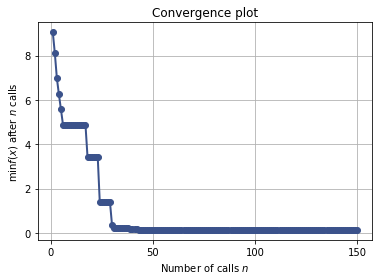

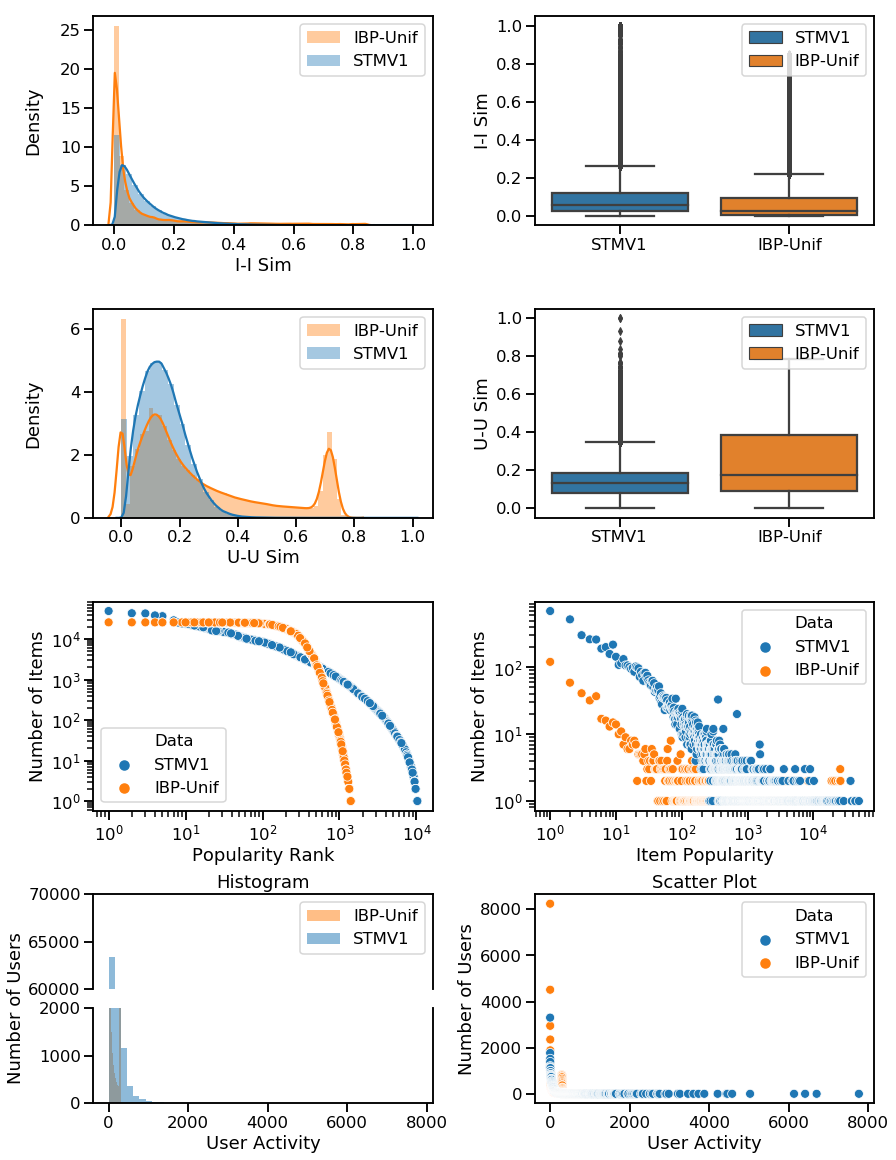

In [29]:
res_gp = skopt.load('build/gp_minimize_ibp_unif_csr-steam_video_game-icorr.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/ibp_unif_csr-steam_video_game-icorr.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('STMV1', steam_video_game), ('IBP-Unif', simulated_data), args=[70912, *res_gp.x, 'ibp_unif_csr-steam_video_game-icorr.pkl'],
               ylim_left=((40, 50), (0, 5)), ylim_left2=((70, 80), (40, 50), (0, 10)),
               ylim_left4=((2000, 5000), (0, 1000)), mrated=5)
else:
    print('simulated data is used')
    plot_stats(('STMV1', steam_video_game), ('IBP-Unif', simulated_data), 
               ylim_left=None, ylim_left2=None,
               ylim_left4=((60000, 70000), (0, 2000)), mrated=5)

### ibp unif on user user

[158.82487094142178, 0.7802949406539271, 0.24137676858796808, 1.064203774139406, 0.2090727054286886, 7488.332379000186] 0.27372110715476256
simulated data is used
dataset stats
    dataset  nusers  nitems   npairs   density
0     STMV1   70912   10978  5094082  0.006544
1  IBP-Unif   70912    6471  3665894  0.007989
item popularity stats
              STMV1      IBP-Unif
count  10978.000000   6471.000000
mean     464.026416    566.511204
std     1793.593696   2287.000697
min        1.000000      1.000000
25%        9.000000      1.000000
50%       43.000000      6.000000
75%      220.000000     57.500000
max    49136.000000  24188.000000
user profile stats
              STMV1      IBP-Unif
count  70912.000000  70912.000000
mean      71.836671     51.696384
std      132.366763     62.088410
min        1.000000      1.000000
25%       14.000000      3.000000
50%       40.000000     14.000000
75%       87.000000    126.000000
max     7762.000000    187.000000


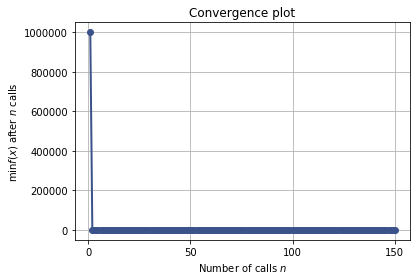

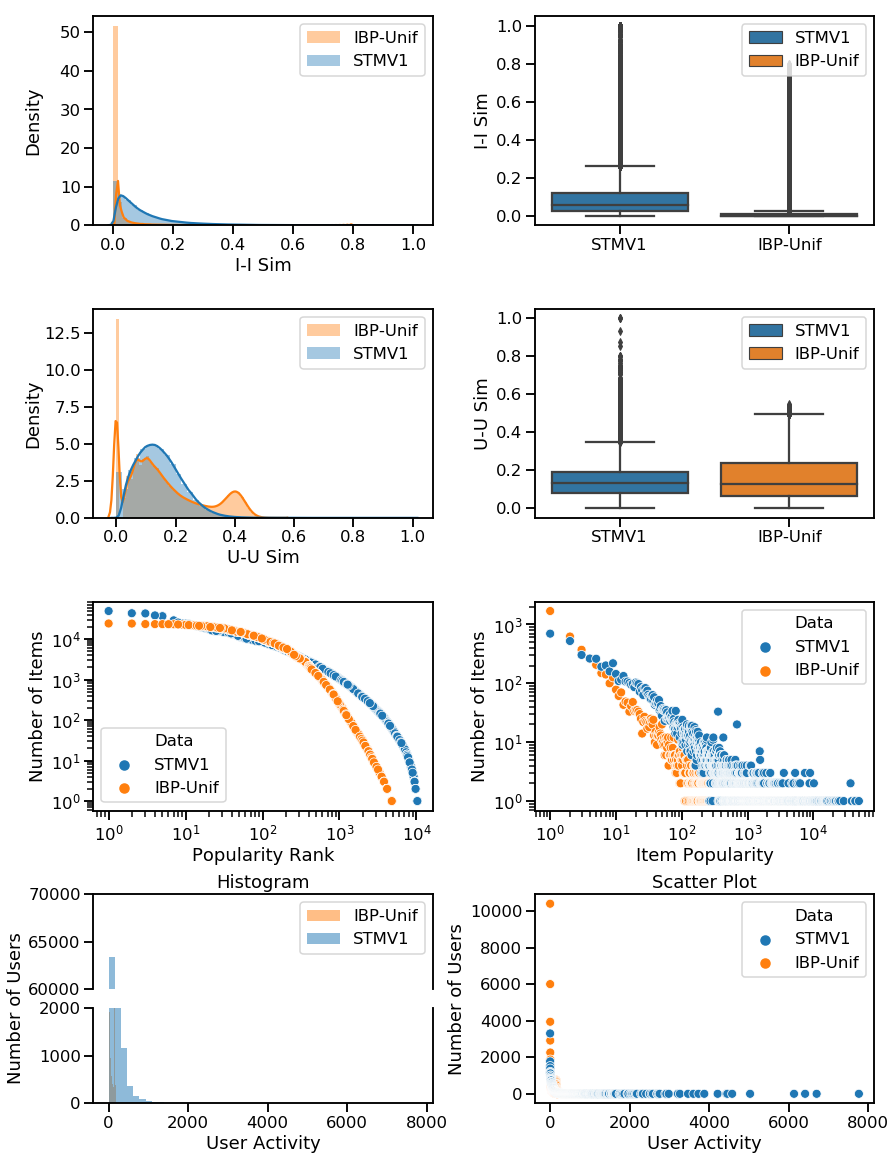

In [30]:
res_gp = skopt.load('build/gp_minimize_ibp_unif_csr-steam_video_game-ucorr.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/ibp_unif_csr-steam_video_game-ucorr.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('stmvg', steam_video_game), ('ibp_unif', ibp_unif_pareto), args=[70912, *res_gp.x, 'ibp_unif_csr-steam_video_game-ucorr.pkl'],
               ylim_left=((40, 50), (0, 20)), ylim_left2=((70, 80), (40, 50), (0, 10)),
               ylim_left4=((2000, 5000), (0, 1000)), mrated=5)
else:
    print('simulated data is used')
    plot_stats(('STMV1', steam_video_game), ('IBP-Unif', simulated_data), 
               ylim_left=None, ylim_left2=None,
               ylim_left4=((60000, 70000), (0, 2000)), mrated=5)

### ibp unif on item pop

[10.0, 60.628719545328245, 0.0, 1.2, 0.1, 5462.759576108949] 0.35120797042494023
simulated data is used
dataset stats
    dataset  nusers  nitems   npairs   density
0     STMV1   70912   10978  5094082  0.006544
1  IBP-Unif   70911    4498   623348  0.001954
item popularity stats
              STMV1     IBP-Unif
count  10978.000000  4498.000000
mean     464.026416   138.583370
std     1793.593696   334.266504
min        1.000000     1.000000
25%        9.000000     3.000000
50%       43.000000    19.000000
75%      220.000000   108.750000
max    49136.000000  6204.000000
user profile stats
              STMV1      IBP-Unif
count  70912.000000  70911.000000
mean      71.836671      8.790568
std      132.366763      4.816894
min        1.000000      1.000000
25%       14.000000      5.000000
50%       40.000000      9.000000
75%       87.000000     12.000000
max     7762.000000     27.000000


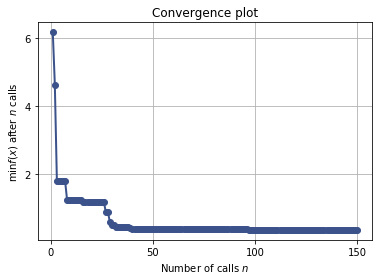

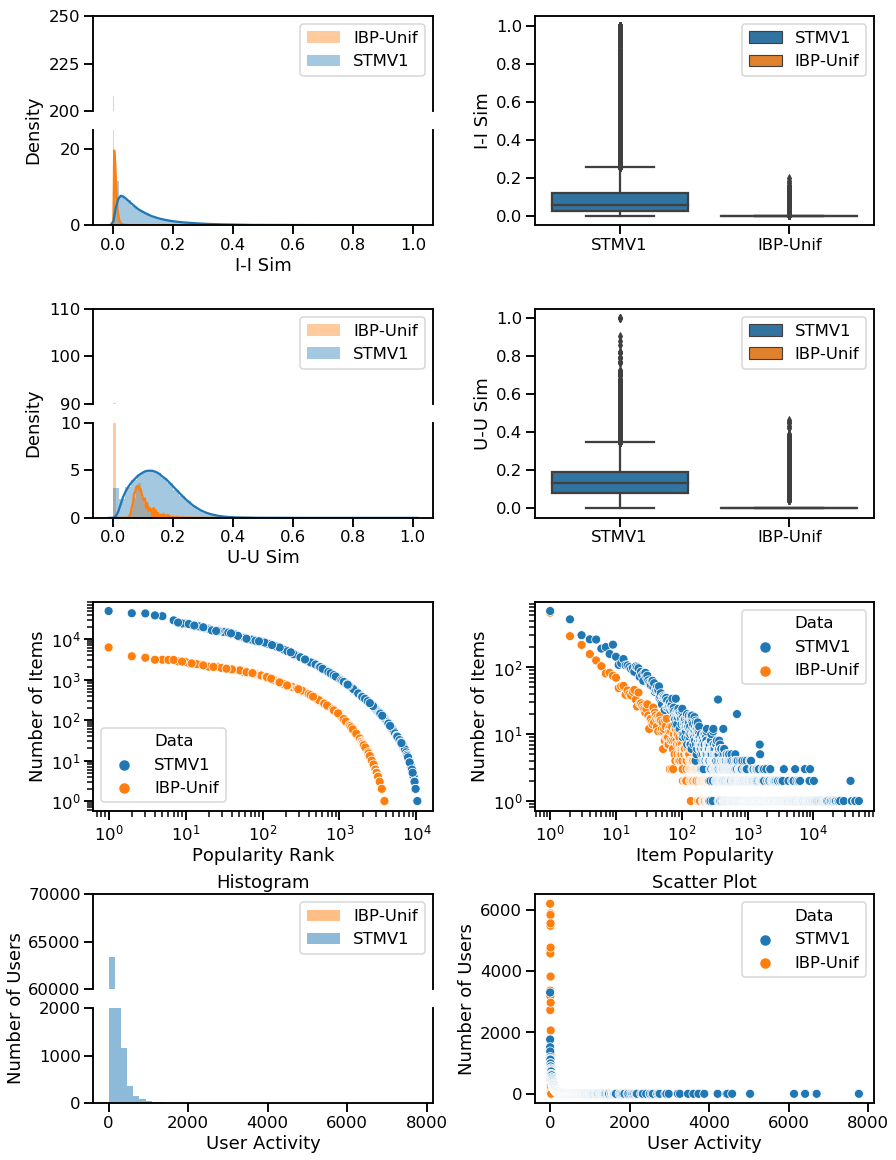

In [25]:
res_gp = skopt.load('build/gp_minimize_ibp_unif_csr-steam_video_game-item-pop.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/ibp_unif_csr-steam_video_game-item-pop.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('stmvg', steam_video_game), ('ibp_unif', ibp_unif_pareto), args=[70912, *res_gp.x, 'ibp_unif_csr-steam_video_game-item-pop.pkl'],
               ylim_left=((40, 50), (0, 20)), ylim_left2=((70, 80), (40, 50), (0, 10)),
               ylim_left4=((2000, 5000), (0, 1000)), mrated=5)
else:
    print('simulated data is used')
    plot_stats(('STMV1', steam_video_game), ('IBP-Unif', simulated_data), 
               ylim_left=((200, 250), (0, 25)), ylim_left2=((90, 110), (0, 10)),
               ylim_left4=((60000, 70000), (0, 2000)), mrated=5)

### ibp unif on user activity

[499.99999999999994, 23.740665110602883, 0.99, 1.2, 0.1, 2000.0000000000002] 0.35502571225927537
simulated data is used
dataset stats
    dataset  nusers   nitems   npairs   density
0     STMV1   70912    10978  5094082  0.006544
1  IBP-Unif   70912  3311073  3548085  0.000015
item popularity stats
              STMV1      IBP-Unif
count  10978.000000  3.311073e+06
mean     464.026416  1.071582e+00
std     1793.593696  4.805361e+00
min        1.000000  1.000000e+00
25%        9.000000  1.000000e+00
50%       43.000000  1.000000e+00
75%      220.000000  1.000000e+00
max    49136.000000  4.495000e+03
user profile stats
              STMV1      IBP-Unif
count  70912.000000  70912.000000
mean      71.836671     50.035043
std      132.366763     44.050351
min        1.000000      1.000000
25%       14.000000      5.000000
50%       40.000000     36.000000
75%       87.000000     96.000000
max     7762.000000    141.000000


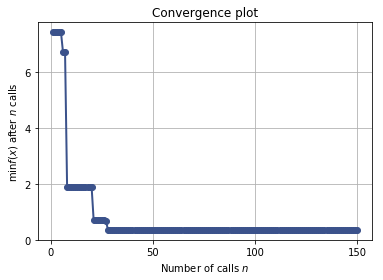

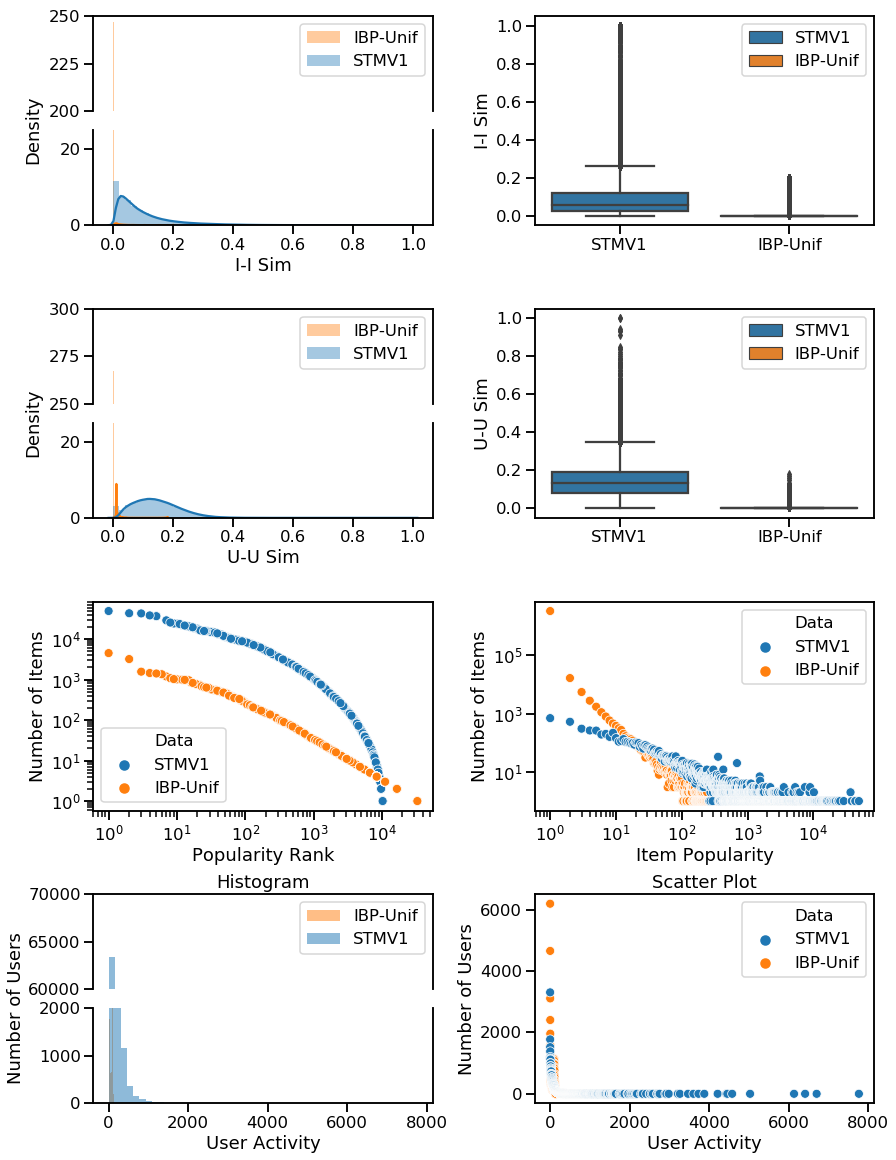

In [ ]:
res_gp = skopt.load('build/gp_minimize_ibp_unif_csr-steam_video_game-user-act.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/ibp_unif_csr-steam_video_game-user-act.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('stmvg', steam_video_game), ('ibp_unif', ibp_unif_pareto), args=[70912, *res_gp.x, 'ibp_unif_csr-steam_video_game-user-act.pkl'],
               ylim_left=((40, 50), (0, 20)), ylim_left2=((70, 80), (40, 50), (0, 10)),
               ylim_left4=((2000, 5000), (0, 1000)), mrated=5)
else:
    print('simulated data is used')
    plot_stats(('STMV1', steam_video_game), ('IBP-Unif', simulated_data), 
               ylim_left=((200, 250), (0, 25)), ylim_left2=((250, 300), (0, 25)),
               ylim_left4=((60000, 70000), (0, 2000)), mrated=5)

### ibp unif on relative loss

[27.202247193049903, 0.43894641182016236, 0.2899771461425498, 1.1195885653991389, 1.6712045872100054, 7318.825078367241] 19.082388540193826
simulated data is used
dataset stats
    dataset  nusers  nitems   npairs   density
0     STMV1   70912   10978  5094082  0.006544
1  IBP-Unif   70912     752   153812  0.002884
item popularity stats
              STMV1     IBP-Unif
count  10978.000000   752.000000
mean     464.026416   204.537234
std     1793.593696   709.759130
min        1.000000     1.000000
25%        9.000000     1.000000
50%       43.000000     4.000000
75%      220.000000    28.000000
max    49136.000000  4921.000000
user profile stats
              STMV1      IBP-Unif
count  70912.000000  70912.000000
mean      71.836671      2.169055
std      132.366763      3.080630
min        1.000000      1.000000
25%       14.000000      1.000000
50%       40.000000      1.000000
75%       87.000000      2.000000
max     7762.000000     42.000000


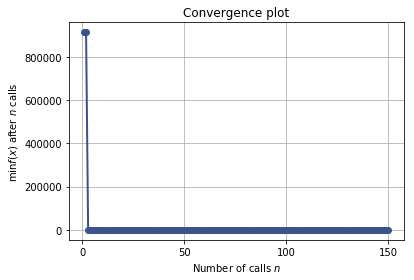

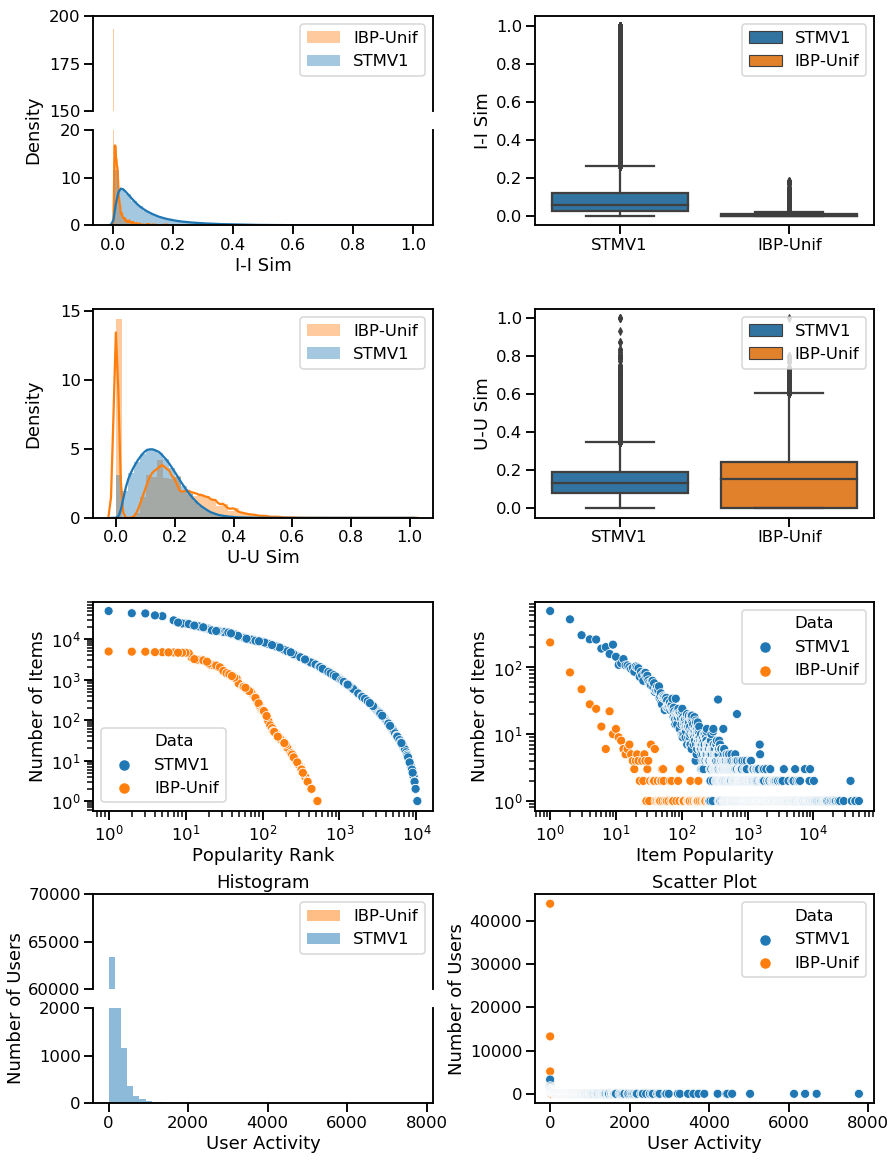

In [47]:
res_gp = skopt.load('build/skopt_ibp_unif-steam_video_game.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/ibp_unif-steam_video_game.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('STMV1', steam_video_game), ('IBP-Unif', ibp_unif_pareto), args=[70912, *res_gp.x, 'ibp_unif-steam_video_game.pkl'])
else:
    print('simulated data is used')
    plot_stats(('STMV1', steam_video_game), ('IBP-Unif', simulated_data), 
               ylim_left=((150, 200), (0, 20)),
               ylim_left4=((60000, 70000), (0, 2000)), mrated=5)

### ibp pop on item item

[499.99999999999994, 0.10937101787313515, 0.11073247134988055, 1.2, 0.1, 2000.0000000000002] 0.21645628445879903
simulated data is used
dataset stats
   dataset  nusers  nitems   npairs   density
0    STMV1   70912   10978  5094082  0.006544
1  IBP-Pop   70912     889   793094  0.012581
item popularity stats
              STMV1      IBP-Pop
count  10978.000000   889.000000
mean     464.026416   892.119235
std     1793.593696  1818.592075
min        1.000000     1.000000
25%        9.000000     6.000000
50%       43.000000    41.000000
75%      220.000000   623.000000
max    49136.000000  7895.000000
user profile stats
              STMV1       IBP-Pop
count  70912.000000  70912.000000
mean      71.836671     11.184200
std      132.366763     26.824063
min        1.000000      1.000000
25%       14.000000      1.000000
50%       40.000000      2.000000
75%       87.000000      6.000000
max     7762.000000    167.000000


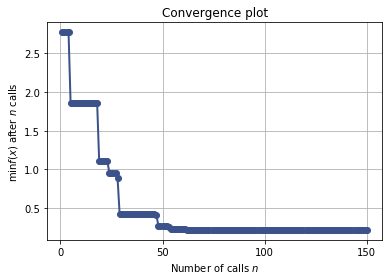

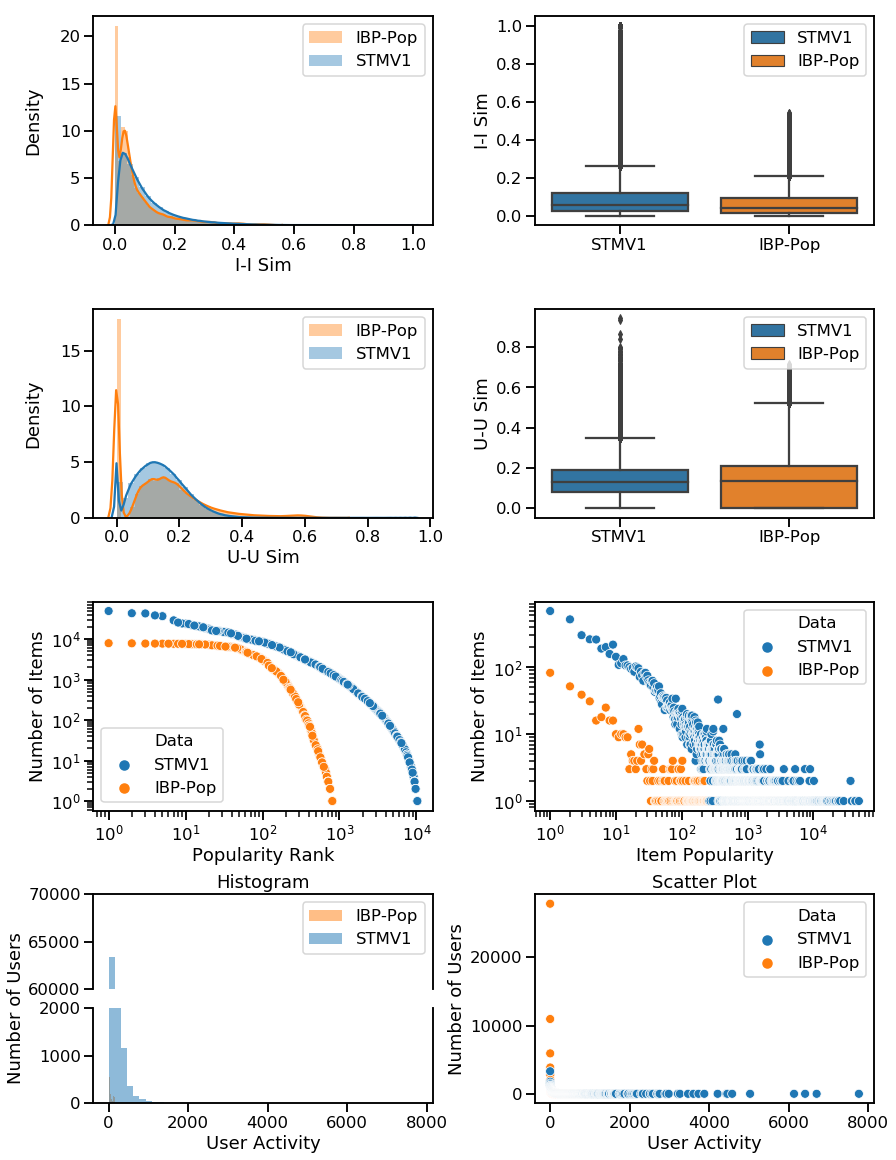

In [34]:
res_gp = skopt.load('build/gp_minimize_ibp_pop_csr-steam_video_game-icorr.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/ibp_pop_csr-steam_video_game-icorr.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('STMV1', steam_video_game), ('IBP-Pop', ibp_pop_pareto), args=[70912, *res_gp.x, 'ibp_pop_csr-steam_video_game-icorr.pkl'],
               ylim_left=((40, 50), (0, 20)), ylim_left2=((70, 80), (40, 50), (0, 10)),
               ylim_left4=((2000, 5000), (0, 1000)), mrated=5)
else:
    print('simulated data is used')
    plot_stats(('STMV1', steam_video_game), ('IBP-Pop', simulated_data),
               ylim_left=None, ylim_left2=None,
               ylim_left4=((60000, 70000), (0, 2000)), mrated=5)

### ibp pop on user user

[154.62237875477433, 1.3617948234110604, 0.47449241482946547, 1.0878507899676557, 0.9056287174323319, 7422.476785767285] 0.3393764986119676
simulated data is used
dataset stats
   dataset  nusers  nitems   npairs   density
0    STMV1   70912   10978  5094082  0.006544
1  IBP-Pop   70912    9535   520293  0.000769
item popularity stats
              STMV1      IBP-Pop
count  10978.000000  9535.000000
mean     464.026416    54.566649
std     1793.593696   372.049781
min        1.000000     1.000000
25%        9.000000     1.000000
50%       43.000000     2.000000
75%      220.000000     6.000000
max    49136.000000  8488.000000
user profile stats
              STMV1       IBP-Pop
count  70912.000000  70912.000000
mean      71.836671      7.337164
std      132.366763     19.932322
min        1.000000      1.000000
25%       14.000000      1.000000
50%       40.000000      2.000000
75%       87.000000      5.000000
max     7762.000000    190.000000


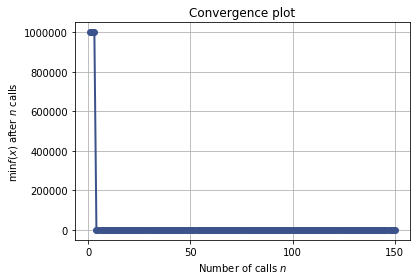

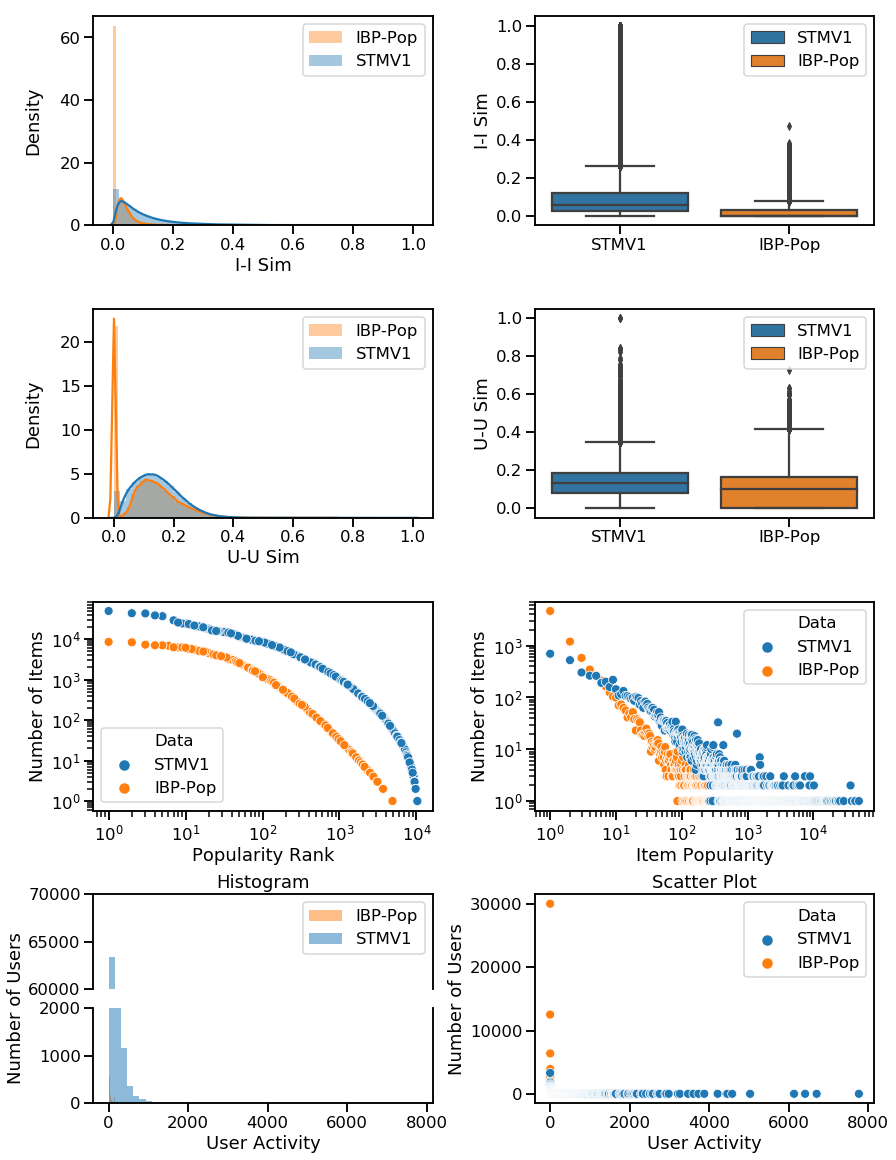

In [35]:
res_gp = skopt.load('build/gp_minimize_ibp_pop_csr-steam_video_game-ucorr.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/ibp_pop_csr-steam_video_game-ucorr.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('stmvg', steam_video_game), ('ibp_pop', ibp_pop_pareto), args=[70912, 10978, *res_gp.x, 'ibp_pop_csr-steam_video_game-ucorr.pkl'],
               ylim_left=((40, 50), (0, 20)), ylim_left2=((70, 80), (40, 50), (0, 10)),
               ylim_left4=((2000, 5000), (0, 1000)), mrated=5)
else:
    print('simulated data is used')
    plot_stats(('STMV1', steam_video_game), ('IBP-Pop', simulated_data), 
               ylim_left=None, ylim_left2=None,
               ylim_left4=((60000, 70000), (0, 2000)), mrated=5)

### ibp pop on item pop

[10.0, 70.58172403455981, 0.0, 1.2, 0.1, 9314.4] 0.38245324441123385
simulated data is used
dataset stats
   dataset  nusers  nitems   npairs   density
0    STMV1   70912   10978  5094082  0.006544
1  IBP-Pop   70904    3767   537211  0.002011
item popularity stats
              STMV1      IBP-Pop
count  10978.000000  3767.000000
mean     464.026416   142.609769
std     1793.593696   364.402871
min        1.000000     1.000000
25%        9.000000     3.000000
50%       43.000000    16.000000
75%      220.000000   104.000000
max    49136.000000  5944.000000
user profile stats
              STMV1       IBP-Pop
count  70912.000000  70904.000000
mean      71.836671      7.576597
std      132.366763      4.072174
min        1.000000      1.000000
25%       14.000000      4.000000
50%       40.000000      8.000000
75%       87.000000     10.000000
max     7762.000000     24.000000


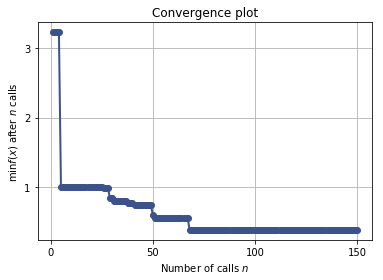

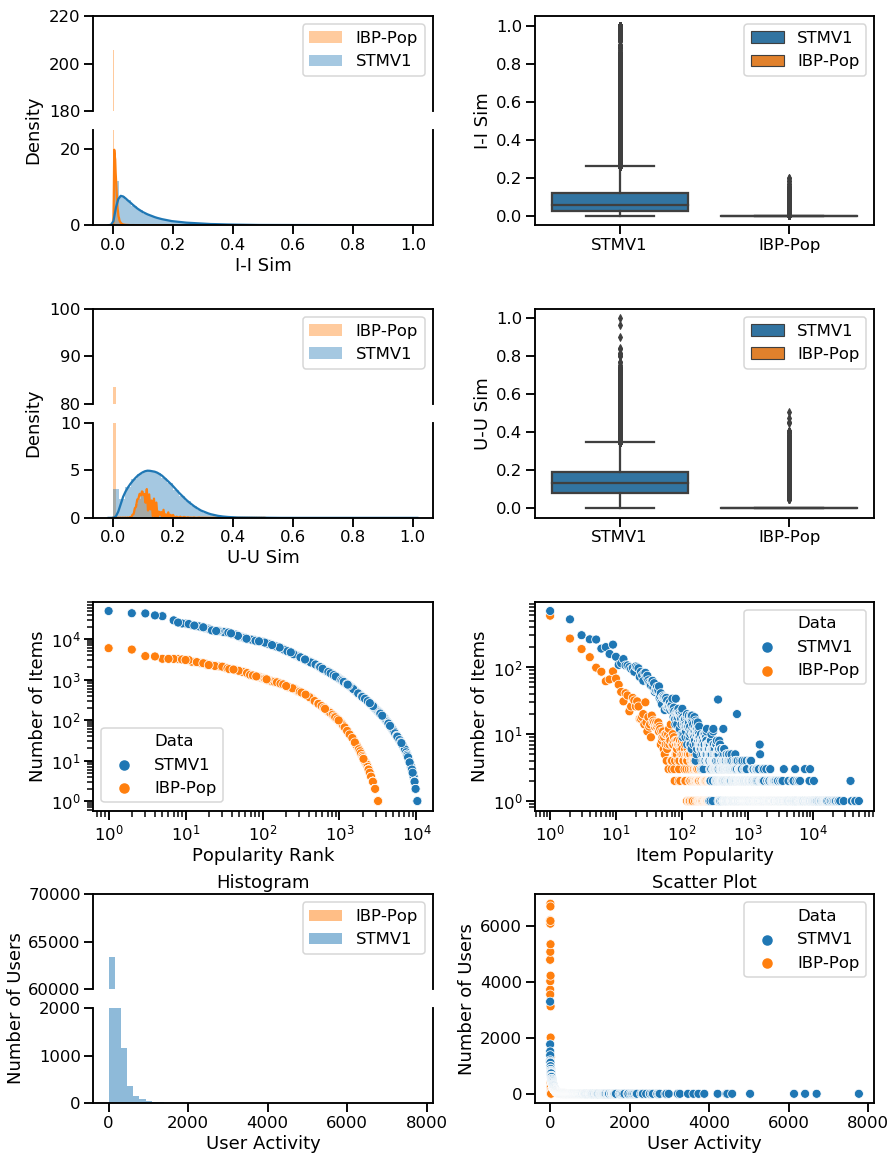

In [ ]:
res_gp = skopt.load('build/gp_minimize_ibp_pop_csr-steam_video_game-item-pop.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/ibp_pop_csr-steam_video_game-item-pop.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('stmvg', steam_video_game), ('ibp_pop', ibp_pop_pareto), args=[70912, *res_gp.x, 'ibp_pop_csr-steam_video_game-item-pop.pkl'],
               ylim_left=((40, 50), (0, 20)), ylim_left2=((70, 80), (40, 50), (0, 10)),
               ylim_left4=((2000, 5000), (0, 1000)), mrated=1)
else:
    print('simulated data is used')
    plot_stats(('STMV1', steam_video_game), ('IBP-Pop', simulated_data), 
               ylim_left=((180, 220), (0, 25)), ylim_left2=((80, 100), (0, 10)),
               ylim_left4=((60000, 70000), (0, 2000)), mrated=5)

### ibp pop on user act

[499.99999999999994, 99.99999811066775, 0.99, 1.1, 0.1621492726312163, 6985.8] 0.44425658970208504
simulated data is used
dataset stats
   dataset  nusers   nitems   npairs   density
0    STMV1   70912    10978  5094082  0.006544
1  IBP-Pop   70912  8456770  9301644  0.000016
item popularity stats
              STMV1       IBP-Pop
count  10978.000000  8.456770e+06
mean     464.026416  1.099905e+00
std     1793.593696  4.058052e+00
min        1.000000  1.000000e+00
25%        9.000000  1.000000e+00
50%       43.000000  1.000000e+00
75%      220.000000  1.000000e+00
max    49136.000000  2.852000e+03
user profile stats
              STMV1       IBP-Pop
count  70912.000000  70912.000000
mean      71.836671    131.171649
std      132.366763    189.219948
min        1.000000      1.000000
25%       14.000000      4.000000
50%       40.000000     20.000000
75%       87.000000    195.000000
max     7762.000000    581.000000


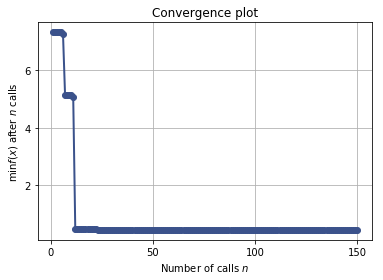

In [ ]:
res_gp = skopt.load('build/gp_minimize_ibp_pop_csr-steam_video_game-user-act.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/ibp_pop_csr-steam_video_game-user-act.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('stmvg', steam_video_game), ('ibp_pop', ibp_pop_pareto), args=[70912, *res_gp.x, 'ibp_pop_csr-steam_video_game-user-act.pkl'],
               ylim_left=((40, 50), (0, 20)), ylim_left2=((70, 80), (40, 50), (0, 10)),
               ylim_left4=((2000, 5000), (0, 1000)), mrated=1)
else:
    print('simulated data is used')
    plot_stats(('STMV1', steam_video_game), ('IBP-Pop', simulated_data), 
               ylim_left=((40, None), (0, 20)), ylim_left2=((40, None), (0, 15)),
               ylim_left4=((60000, 70000), (0, 2000)), mrated=5)

### ibp pop on relative loss

[138.0647966898341, 0.037013852640104074, 0.3164617304855642, 1.0863959220978994, 1.2417238979281358, 9098.489227465963] 6.648044304242101
simulated data is used
dataset stats
   dataset  nusers  nitems   npairs   density
0    STMV1   70912   10978  5094082  0.006544
1  IBP-Pop   70912     962   266532  0.003907
item popularity stats
              STMV1      IBP-Pop
count  10978.000000   962.000000
mean     464.026416   277.060291
std     1793.593696   693.133753
min        1.000000     1.000000
25%        9.000000     1.000000
50%       43.000000     4.000000
75%      220.000000    48.000000
max    49136.000000  2842.000000
user profile stats
              STMV1       IBP-Pop
count  70912.000000  70912.000000
mean      71.836671      3.758630
std      132.366763     10.319759
min        1.000000      1.000000
25%       14.000000      1.000000
50%       40.000000      1.000000
75%       87.000000      3.000000
max     7762.000000    157.000000


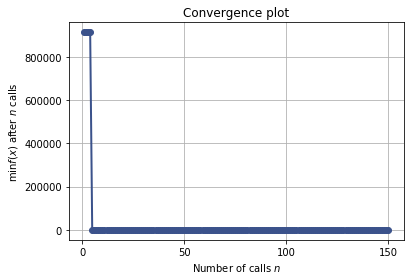

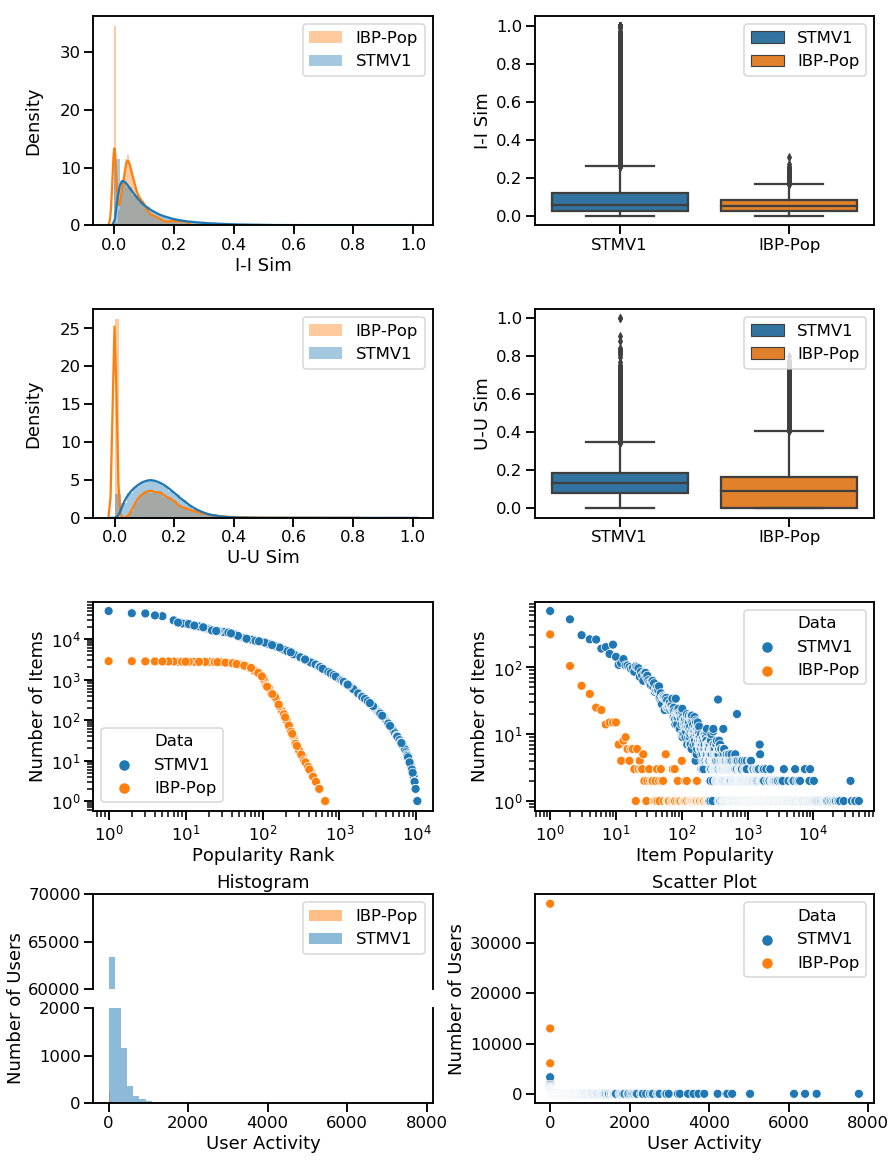

In [38]:
res_gp = skopt.load('build/skopt_ibp_pop-steam_video_game.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/ibp_pop-steam_video_game.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('STMV1', steam_video_game), ('IBP-Pop', ibp_unif_pareto), args=[70912, *res_gp.x, 'ibp_pop-steam_video_game.pkl'])
else:
    print('simulated data is used')
    plot_stats(('STMV1', steam_video_game), ('IBP-Pop', simulated_data),
               ylim_left=None, ylim_left2=None,
               ylim_left4=((60000, 70000), (0, 2000)), mrated=5)

### Unif unif on relative loss

[249.87039912954677, 1.1202513132055123, 0.7595481695936636, 3032.8969834871928] 45.213232434905954
simulated data is used
dataset stats
     dataset  nusers  nitems   npairs   density
0      STMV1   70912   10978  5094082  0.006544
1  UNIF-Unif   70912   10978   880339  0.001131
item popularity stats
              STMV1     UNIF-Unif
count  10978.000000  10978.000000
mean     464.026416     80.191201
std     1793.593696      8.976236
min        1.000000     42.000000
25%        9.000000     74.000000
50%       43.000000     80.000000
75%      220.000000     86.000000
max    49136.000000    118.000000
user profile stats
              STMV1     UNIF-Unif
count  70912.000000  70912.000000
mean      71.836671     12.414528
std      132.366763     36.268684
min        1.000000      1.000000
25%       14.000000      1.000000
50%       40.000000      2.000000
75%       87.000000      6.000000
max     7762.000000    310.000000


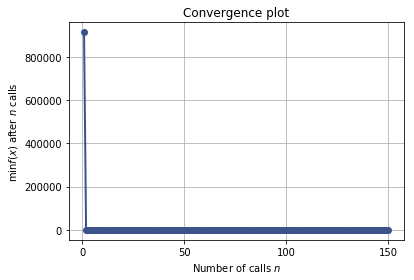

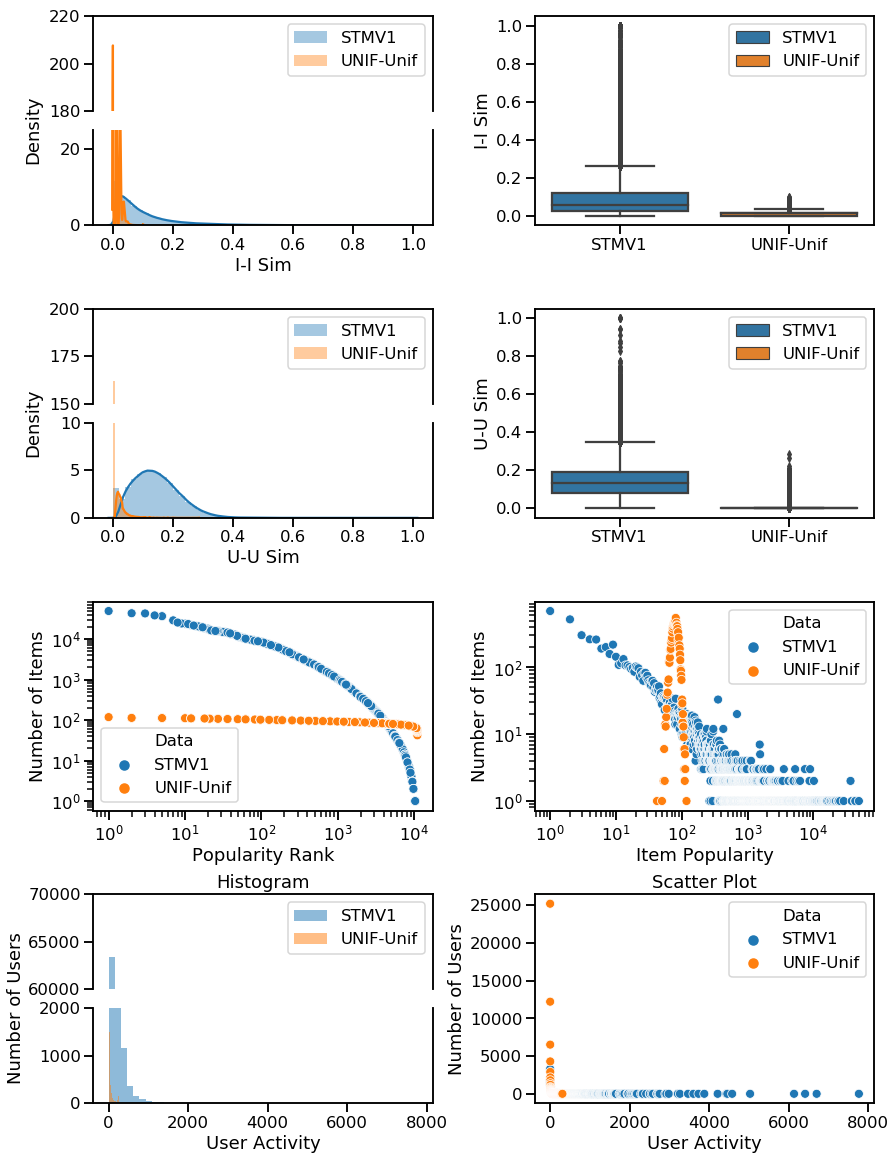

In [46]:
res_gp = skopt.load('build/skopt_unif_unif-steam_video_game.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/unif_unif-steam_video_game.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
else:
    print('simulated data is used')
    plot_stats(('STMV1', steam_video_game), ('UNIF-Unif', simulated_data), mrated=5,
               ylim_left=((180, 220), (0, 25)), ylim_left2=((150, 200),(0, 10)),
               ylim_left4=((60000, 70000), (0, 2000)))

### Unif Pop on relative loss

[182.1723888516143, 1.117220429805652, 1.1023806520277903, 248.76341275245088] 47.43179830296372
simulated data is used
dataset stats
    dataset  nusers  nitems   npairs   density
0     STMV1   70912   10978  5094082  0.006544
1  UNIF-Pop   70912   10978   327694  0.000421
item popularity stats
              STMV1      UNIF-Pop
count  10978.000000  10978.000000
mean     464.026416     29.850064
std     1793.593696      5.634176
min        1.000000     12.000000
25%        9.000000     26.000000
50%       43.000000     30.000000
75%      220.000000     34.000000
max    49136.000000     53.000000
user profile stats
              STMV1      UNIF-Pop
count  70912.000000  70912.000000
mean      71.836671      4.621136
std      132.366763     12.619544
min        1.000000      1.000000
25%       14.000000      1.000000
50%       40.000000      2.000000
75%       87.000000      3.000000
max     7762.000000    217.000000


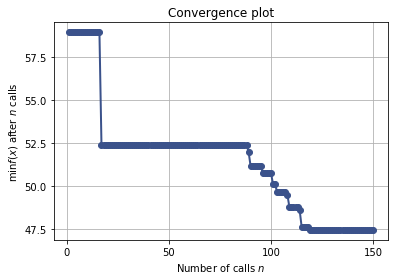

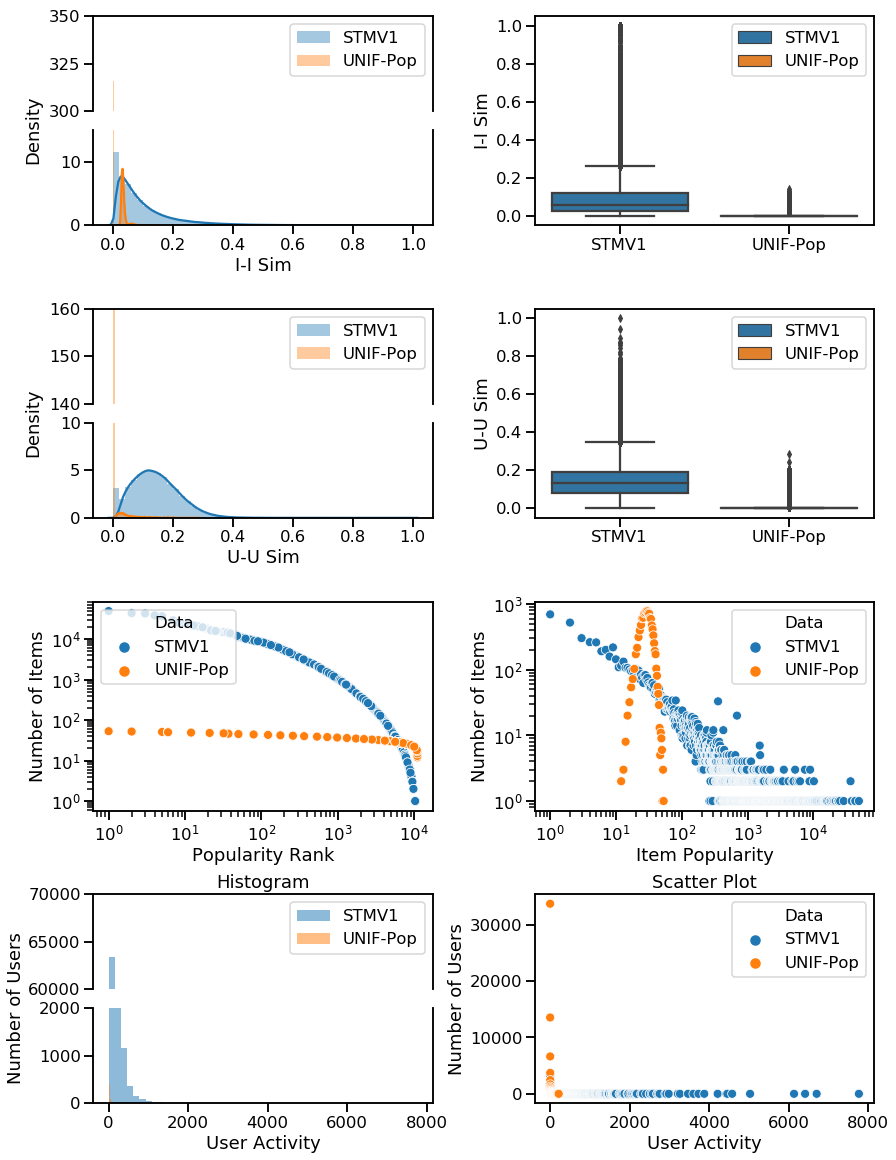

In [45]:
res_gp = skopt.load('build/skopt_unif_pop-steam_video_game.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/unif_pop-steam_video_game.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
else:
    print('simulated data is used')
    plot_stats(('STMV1', steam_video_game), ('UNIF-Pop', simulated_data), mrated=5,
               ylim_left=((300, 350), (0, 15)), ylim_left2=((140, 160),(0, 10)),
               ylim_left4=((60000, 70000), (0, 2000)))